In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("../")

In [3]:
!pip3 install scipy
!pip3 install tabulate

In [4]:
from src.bayesian_PSL import PlayerComparison, RandomVariablePSL, TeamPSL, EPL_Data
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, skew, kurtosis
from scipy.optimize import fsolve
import numpy as np
import IPython.display
import pandas as pd


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
EPL_Full_Data = EPL_Data(
    "../SampleData/epl.xlsx", "../SampleData/players.json", "R_storage.npy"
)

# epl = EPL_Full_Data.get_epl()
# epl_player_data = EPL_Full_Data.get_epl_player_data()
# R_storage = EPL_Full_Data.get_r_storage()
# Q_storage = EPL_Full_Data.get_q_storage()
# partidos = EPL_Full_Data.get_partidos()
# tp_ds = EPL_Full_Data.get_transition_prob_dataset()
# player_ids = EPL_Full_Data.get_player_ids()
# player_kdes = EPL_Full_Data.get_player_kdes()

In [7]:
# Plot CDFs

def plot_psl_cdfs(psls, psls_2, ax=None, names=None, colors=None):
    if names is None:
        names = ["P1", "P2"]

    if colors is None:
        colors = ["b", "r"]

    psl_kde = gaussian_kde(psls)
    psl_kde_2 = gaussian_kde(psls_2)
    
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_xlim(0, 0.4)
    
    x = np.linspace(0, 1, 1000)

    if ax is None:
        _, ax = plt.subplots(figsize=(20, 8))

    # Asegúrate de que x es un array de numpy
    x = np.array(x)

    # Calcula la CDF para cada valor en x
    cdf_1 = np.array([psl_kde.integrate_box_1d(0, xi) for xi in x])
    cdf_2 = np.array([psl_kde_2.integrate_box_1d(0, xi) for xi in x])

    # Grafica las CDFs
    
    ax.plot(x, cdf_1, color=colors[0], label=f"CDF {names[0]}")
    ax.plot(x, cdf_2, color=colors[1], label=f"CDF {names[1]}")
    
    ax.legend()

    ax.set_title(
        f"CDF Distributions"
    )

    plt.show()
    
    return None

def find_intersection(fun1, fun2, x0):
    return fsolve(lambda x: fun1(x) - fun2(x), x0)

def plot_psl_cdfs_intersections(psls, psls_2, ax=None, names=None, colors=None):
    psl_kde = gaussian_kde(psls)
    psl_kde_2 = gaussian_kde(psls_2)
    x = np.linspace(0, 1, 1000)
    cdf_1 = np.array([psl_kde.integrate_box_1d(0, xi) for xi in x])
    cdf_2 = np.array([psl_kde_2.integrate_box_1d(0, xi) for xi in x])

    intersections = find_intersection(
        lambda x: psl_kde.integrate_box_1d(0, x),
        lambda x: psl_kde_2.integrate_box_1d(0, x),
        0.1,
    )
    print(len(intersections))
    print(intersections)
    
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_xlim(0, 0.4)

    plot_psl_cdfs(
        psls,
        psls_2,
        ax=ax,
        names=[names[0], names[1]],
        colors=["b", "r"],
    )
    for intersection in intersections:
        ax.axvline(intersection, color="g", linestyle="--")
    return None



## Study case

We want to observe if our model predicts good performance and an increase in PSL prior to the real transfers in future season
### Main transfers next to seasons:

#### 2013/2014 Season:
Juan Mata: Chelsea to Manchester United - £37.1 million (January 2014)

Romelu Lukaku: Chelsea to Everton - Loan (September 2013)

Andros Townsend: Tottenham Hotspur to Queens Park Rangers - Loan (January 2014)

#### 2014/2015 Season
Danny Welbeck: Manchester United to Arsenal - £16 million (September 2014)

Wilfried Bony: Swansea City to Manchester City - £28 million (January 2015)

Ryan Bertrand: Chelsea to Southampton - Loan, later permanent transfer (January 2015)

In [8]:
def compare_players(team_name, p1, p2, n):
    '''Given p1(a player in the 11 top players of team_name) and p2 (a new player) it compares the performance of team_name with
     p1 and team_name replacing p1 with p2. 
     n is the number of samples to calculate the PSL distributions
     Returns the PSL distribution of the original team and the PSL distribution of the new team with p2 instead of p1.'''
    team = TeamPSL(EPL_Full_Data)
    team.set_team(team_name)
    team_11 = team.calculate_top_11_players()
    psl_original = team.estimate_psl_distribution(n, team_11)
    psl_new = team.estimate_psl_distribution(n, team.replace_player(p1, p2))
    print(p1, p2)

    comp_table = pd.DataFrame(
    [
        [
            np.mean(psl_original),
            np.std(psl_original),
            np.var(psl_original),
            skew(psl_original),
            kurtosis(psl_original),
        ],
        [
            np.mean(psl_new),
            np.std(psl_new),
            np.var(psl_new),
            skew(psl_new),
            kurtosis(psl_new),
        ],
    ],
    index=[p1, p2],
    columns=["Media", "Varianza", "Desvio Estándar", "Skewness", "Kurtosis"],
)


    plot_psl_cdfs(psl_original, psl_new, names= [p1, p2])
    #plot_psl_cdfs_intersections(psl_original, psl_new, names= [p1, p2])
    
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_xlim(0, 0.4)

    RandomVariablePSL.plot_psl_distributions(
        psl_original, psl_new, ax=ax, names=[p1, p2], colors=["b", "r"]
    )
    plt.show()
    
    IPython.display.display(IPython.display.Markdown(comp_table.to_markdown()))
    print(comp_table.to_latex())
    
    

    return psl_original, psl_new

## Juan Mata

In [10]:
#Juan Mata(M, 43670): Chelsea to Manchester United - £37.1 million (January 2014)
#Compare with Michael Carrick M 2404 and Wayne Rooney F 13017
team_psl_ManU = TeamPSL(EPL_Full_Data)
team_psl_ManU.set_team("Manchester United")
manU_11 =team_psl_ManU.calculate_top_11_players()
#Apliying the function to every position of the list
for i in manU_11:
    print(EPL_Full_Data.get_epl_player_data().get_player_name(i), EPL_Full_Data.get_epl_player_data().get_player_position(i), i)

print(EPL_Full_Data.get_epl_player_data().get_player_id_by_name("Juan Mata"))

Robin van Persie F 12297.0
Michael Carrick M 2404.0
Patrice Evra D 14075.0
David de Gea G 51940.0
Rio Ferdinand D 2034.0
Rafael D 54772.0
Antonio Valencia D 20695.0
None None 37642.0
Wayne Rooney F 13017.0
Danny Welbeck F 50175.0
Nemanja Vidic D 14965.0
43670


In [ ]:
man_U11 = team_psl_ManU.calculate_top_11_players()
psl_carrick = team_psl_ManU.estimate_psl_distribution(1000, man_U11)
psl_mata = team_psl_ManU.estimate_psl_distribution(1000, team_psl_ManU.replace_player("Michael Carrick", "Juan Mata"))

100%|██████████| 1000/1000 [01:00<00:00, 16.56it/s]


Finding replacement for player with same position
Old Player: Michael Carrick - 2404
Old Player Position: M
[12297.0, 2404.0, 14075.0, 51940.0, 2034.0, 54772.0, 20695.0, 37642.0, 13017.0, 50175.0, 14965.0]
['F', 'M', 'D', 'G', 'D', 'D', 'D', None, 'F', 'F', 'D']


100%|██████████| 1000/1000 [00:58<00:00, 17.21it/s]


Michael Carrick Juan Mata


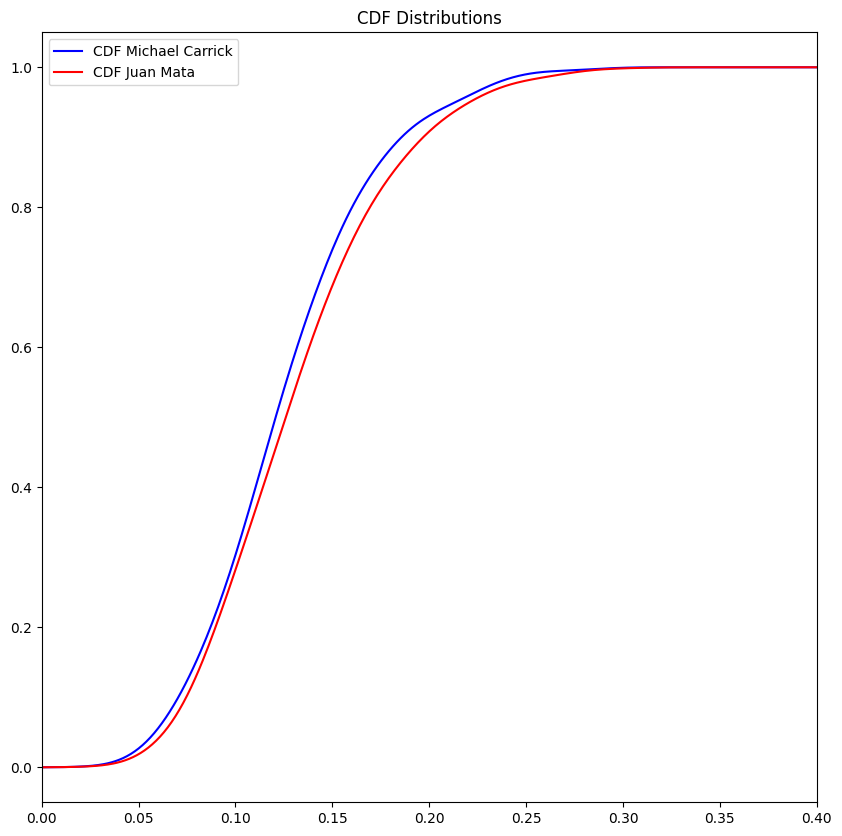

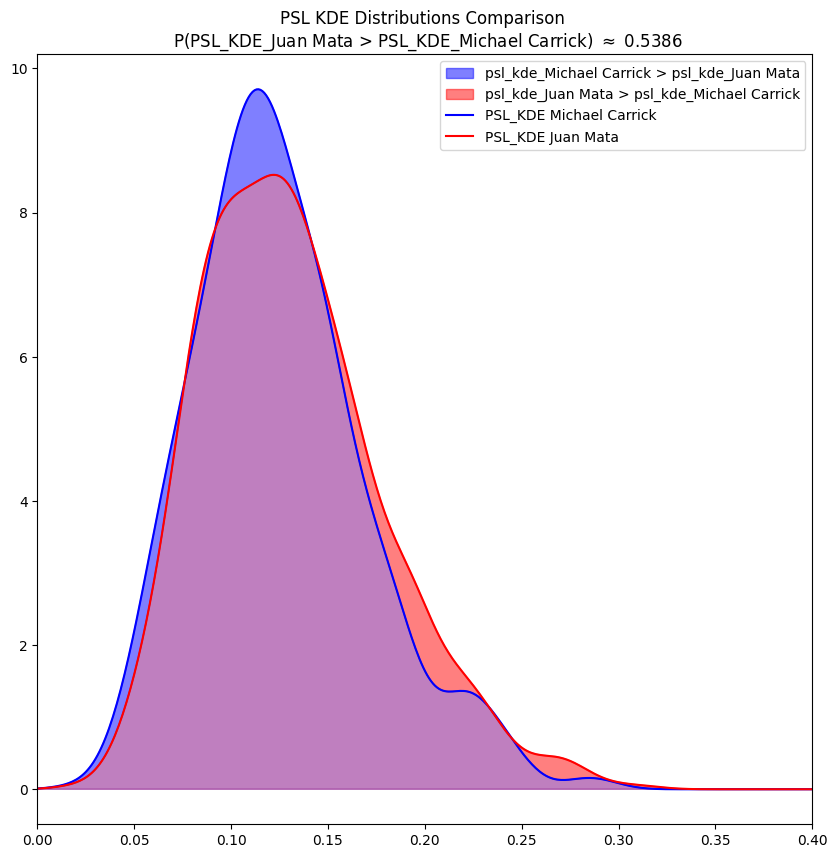

|                 |    Media |   Varianza |   Desvio Estándar |   Skewness |   Kurtosis |
|:----------------|---------:|-----------:|------------------:|-----------:|-----------:|
| Michael Carrick | 0.125424 |  0.0443871 |        0.00197022 |   0.679548 |   0.570581 |
| Juan Mata       | 0.131326 |  0.0467948 |        0.00218976 |   0.696423 |   0.424845 |

\begin{tabular}{lrrrrr}
\toprule
{} &     Media &  Varianza &  Desvio Estándar &  Skewness &  Kurtosis \\
\midrule
Michael Carrick &  0.125424 &  0.044387 &          0.00197 &  0.679548 &  0.570581 \\
Juan Mata       &  0.131326 &  0.046795 &          0.00219 &  0.696423 &  0.424845 \\
\bottomrule
\end{tabular}



100%|██████████| 1000/1000 [00:54<00:00, 18.39it/s]


Finding replacement for player with same position
Old Player: Wayne Rooney - 13017
Old Player Position: F
[12297.0, 2404.0, 14075.0, 51940.0, 2034.0, 54772.0, 20695.0, 37642.0, 13017.0, 50175.0, 14965.0]
['F', 'M', 'D', 'G', 'D', 'D', 'D', None, 'F', 'F', 'D']


100%|██████████| 1000/1000 [00:54<00:00, 18.30it/s]


Wayne Rooney Juan Mata


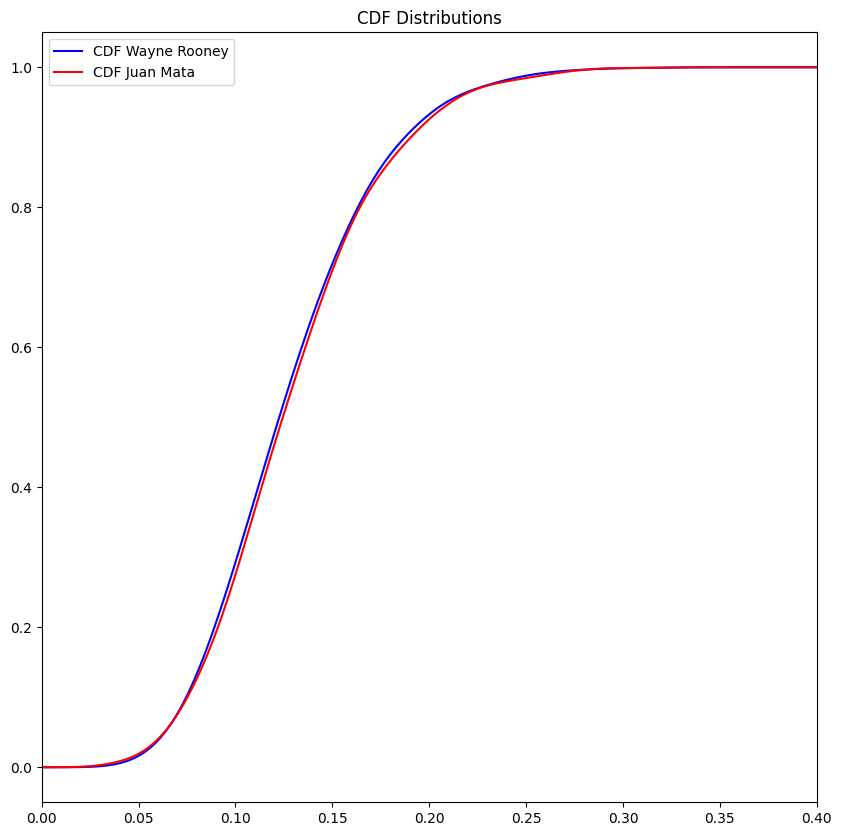

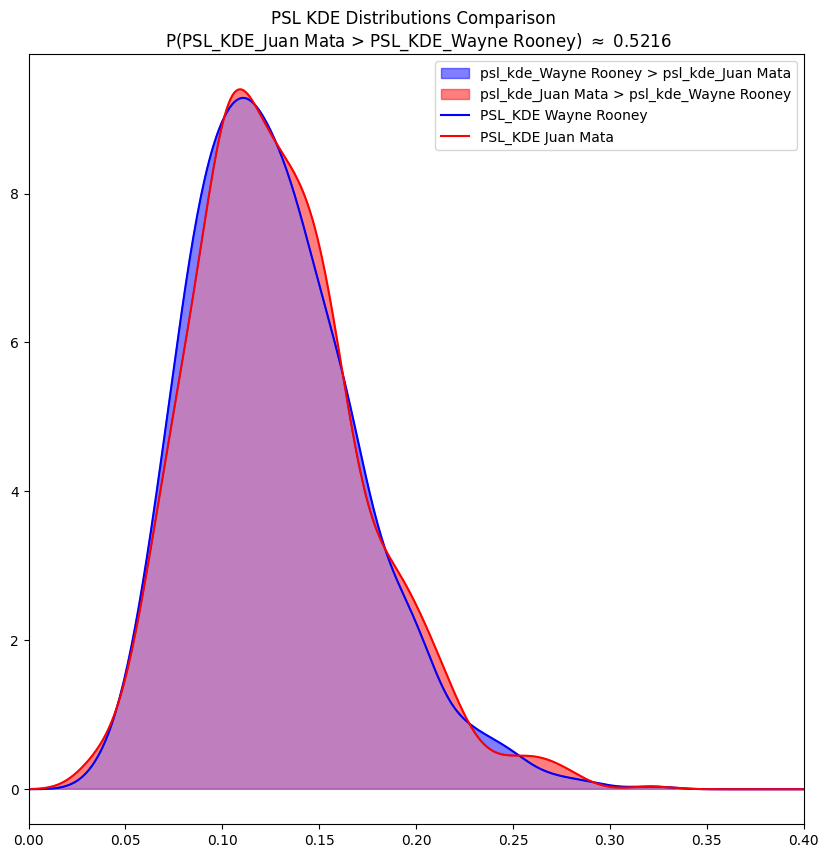

|              |    Media |   Varianza |   Desvio Estándar |   Skewness |   Kurtosis |
|:-------------|---------:|-----------:|------------------:|-----------:|-----------:|
| Wayne Rooney | 0.12763  |  0.0435535 |        0.00189691 |   0.724476 |   0.66534  |
| Juan Mata    | 0.129189 |  0.0442289 |        0.00195619 |   0.685968 |   0.674491 |

\begin{tabular}{lrrrrr}
\toprule
{} &     Media &  Varianza &  Desvio Estándar &  Skewness &  Kurtosis \\
\midrule
Wayne Rooney &  0.127630 &  0.043553 &         0.001897 &  0.724476 &  0.665340 \\
Juan Mata    &  0.129189 &  0.044229 &         0.001956 &  0.685968 &  0.674491 \\
\bottomrule
\end{tabular}



In [13]:
psl_carrick, psl_mata = compare_players("Manchester United", "Michael Carrick", "Juan Mata", 1000)
psl_rooney, psl_mata = compare_players("Manchester United", "Wayne Rooney", "Juan Mata", 1000)



## Romelu Lukaku

In [14]:
#Romelu Lukaku (F, 66749): Chelsea to Everton - Loan (September 2013)

#Compare with Nikica Jelavic F 62419, Steven Pienaar M 7525
#Everton
team_psl_EV = TeamPSL(EPL_Full_Data)
team_psl_EV.set_team("Everton")
everton = team_psl_EV.calculate_top_11_players()
for i in everton:
    print(EPL_Full_Data.get_epl_player_data().get_player_name(i), EPL_Full_Data.get_epl_player_data().get_player_position(i), i)


Leighton Baines D 12745.0
Tim Howard G 15337.0
Phil Jagielka D 7645.0
Leon Osman M 8378.0
Sylvain Distin D 6219.0
Steven Pienaar M 7525.0
Marouane Fellaini M 41184.0
Séamus Coleman D 59949.0
Nikica Jelavic F 62419.0
John Heitinga D 10466.0
Darron Gibson M 27707.0


100%|██████████| 1000/1000 [01:00<00:00, 16.51it/s]


Finding replacement for player with same position
Old Player: Nikica Jelavic - 62419
Old Player Position: F
[12745.0, 15337.0, 7645.0, 8378.0, 6219.0, 7525.0, 41184.0, 59949.0, 62419.0, 10466.0, 27707.0]
['D', 'G', 'D', 'M', 'D', 'M', 'M', 'D', 'F', 'D', 'M']


100%|██████████| 1000/1000 [00:58<00:00, 17.04it/s]


Nikica Jelavic Romelu Lukaku


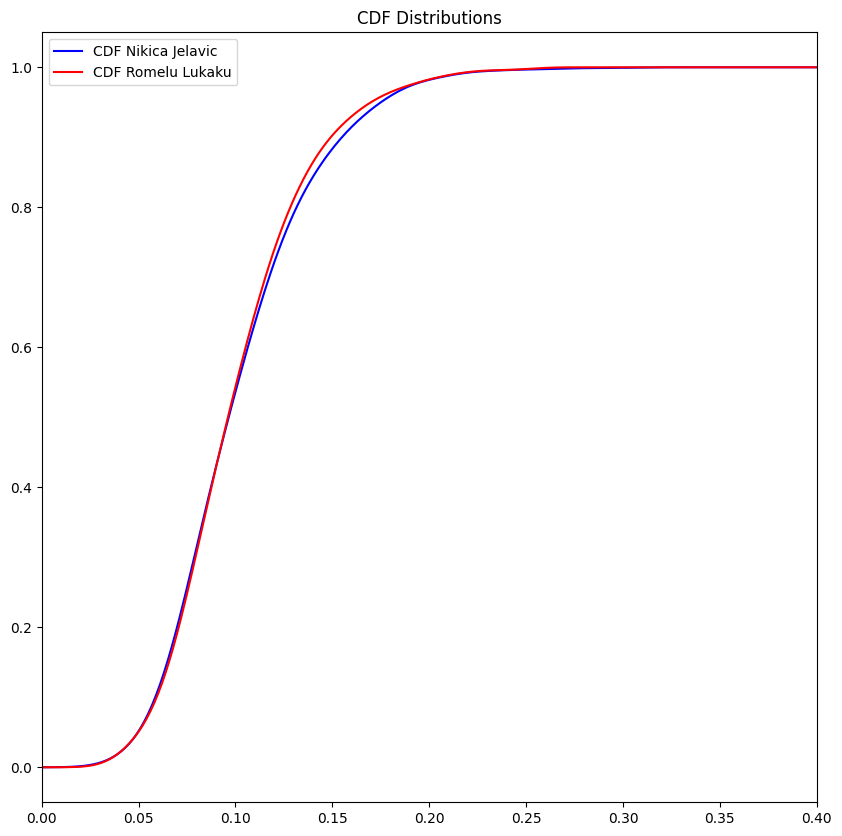

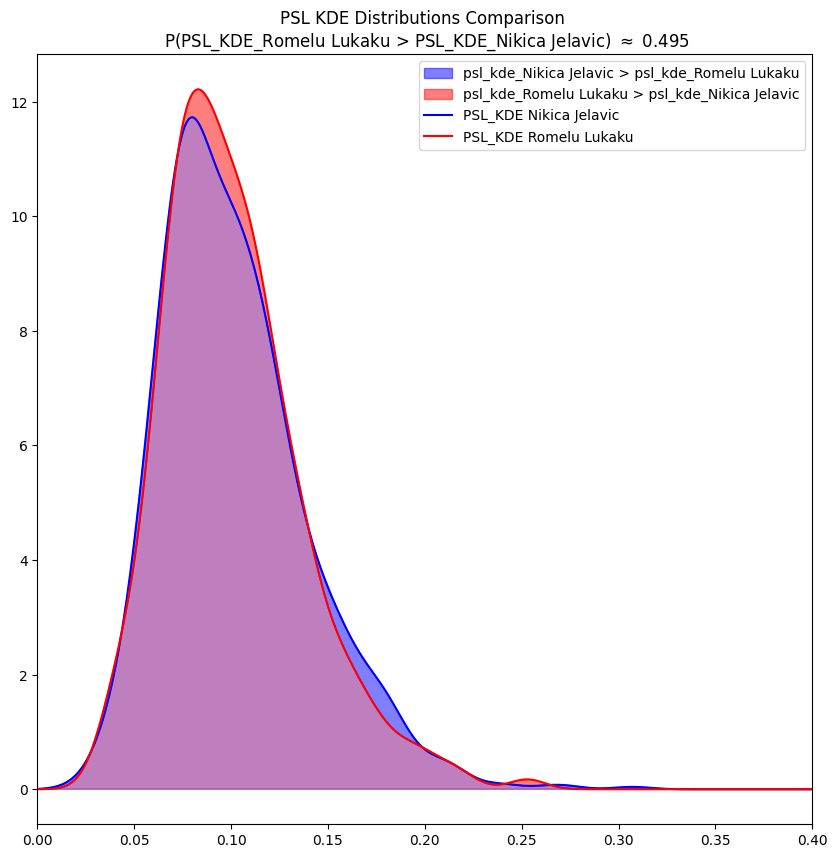

|                |    Media |   Varianza |   Desvio Estándar |   Skewness |   Kurtosis |
|:---------------|---------:|-----------:|------------------:|-----------:|-----------:|
| Nikica Jelavic | 0.102226 |  0.0377716 |        0.00142669 |   0.985853 |    1.61414 |
| Romelu Lukaku  | 0.101063 |  0.0358697 |        0.00128664 |   0.945529 |    1.39002 |

\begin{tabular}{lrrrrr}
\toprule
{} &     Media &  Varianza &  Desvio Estándar &  Skewness &  Kurtosis \\
\midrule
Nikica Jelavic &  0.102226 &  0.037772 &         0.001427 &  0.985853 &  1.614139 \\
Romelu Lukaku  &  0.101063 &  0.035870 &         0.001287 &  0.945529 &  1.390015 \\
\bottomrule
\end{tabular}



100%|██████████| 1000/1000 [00:54<00:00, 18.21it/s]


Finding replacement for player with same position
Old Player: Steven Pienaar - 7525
Old Player Position: M
[12745.0, 15337.0, 7645.0, 8378.0, 6219.0, 7525.0, 41184.0, 59949.0, 62419.0, 10466.0, 27707.0]
['D', 'G', 'D', 'M', 'D', 'M', 'M', 'D', 'F', 'D', 'M']


100%|██████████| 1000/1000 [00:56<00:00, 17.70it/s]


Steven Pienaar Romelu Lukaku


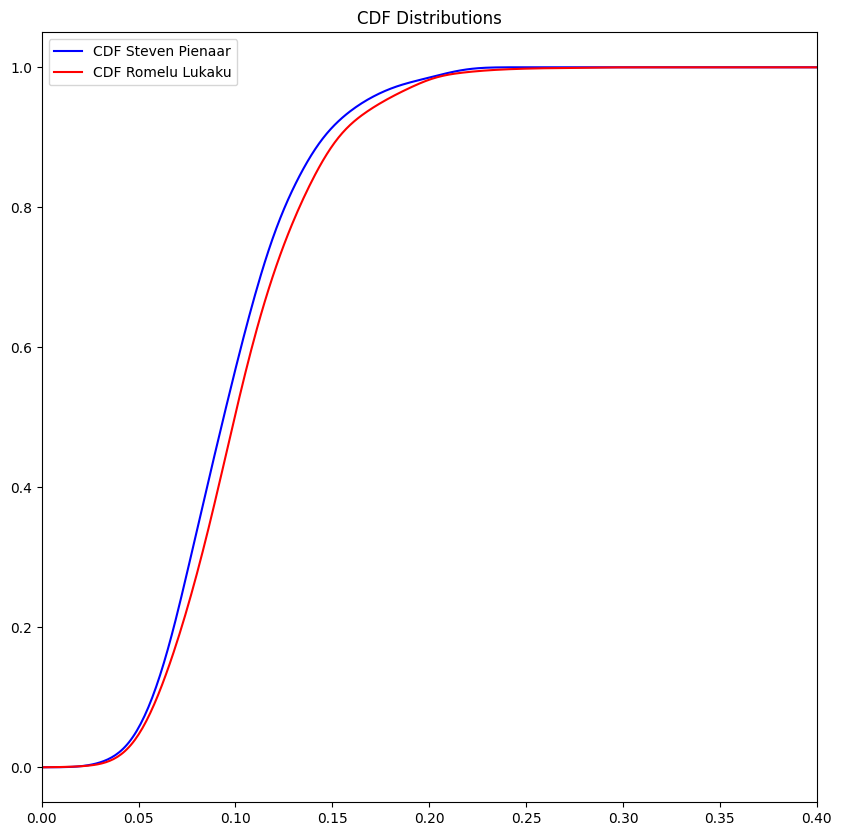

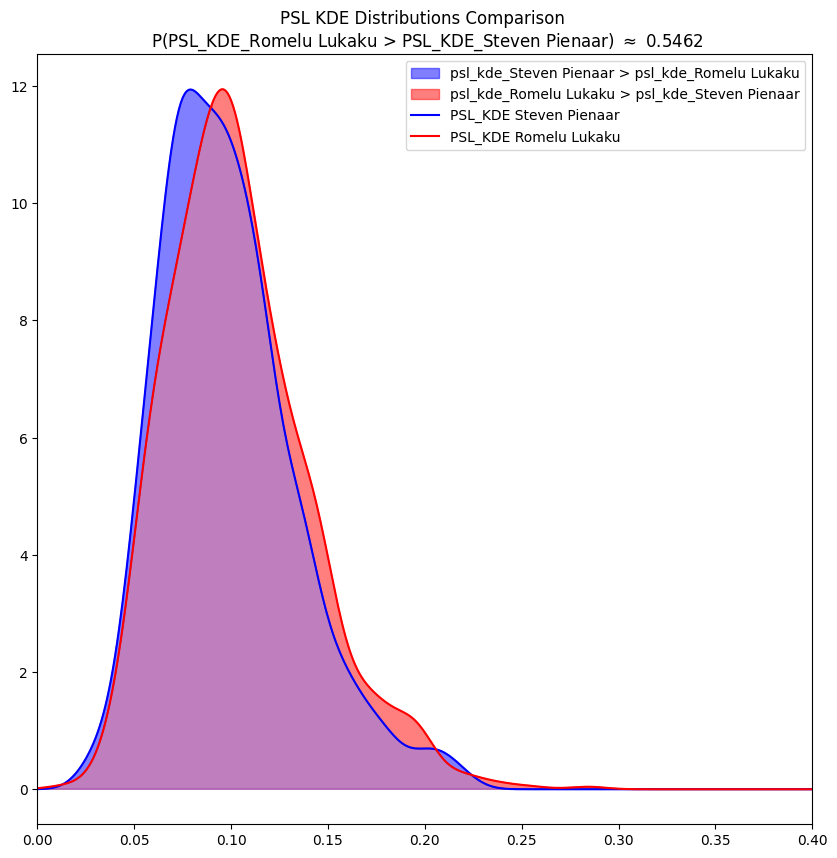

|                |     Media |   Varianza |   Desvio Estándar |   Skewness |   Kurtosis |
|:---------------|----------:|-----------:|------------------:|-----------:|-----------:|
| Steven Pienaar | 0.0983636 |  0.0348261 |        0.00121286 |   0.826606 |   0.786503 |
| Romelu Lukaku  | 0.104047  |  0.0367005 |        0.00134693 |   0.832266 |   1.08814  |

\begin{tabular}{lrrrrr}
\toprule
{} &     Media &  Varianza &  Desvio Estándar &  Skewness &  Kurtosis \\
\midrule
Steven Pienaar &  0.098364 &  0.034826 &         0.001213 &  0.826606 &  0.786503 \\
Romelu Lukaku  &  0.104047 &  0.036701 &         0.001347 &  0.832266 &  1.088136 \\
\bottomrule
\end{tabular}



In [15]:
psl_jelavic, psl_lukaku = compare_players("Everton", "Nikica Jelavic", "Romelu Lukaku", 1000)
psl_pienaar, psl_lukaku = compare_players("Everton", "Steven Pienaar", "Romelu Lukaku", 1000)

## Andros Townsend

In [16]:
#Andros Townsend(60252, Midlefielder): Tottenham Hotspur to Queens Park Rangers - Loan (January 2014)
#Compare against Stéphane Mbia M 27671, Adel Taarabt M 39765, Esteban Granero M 46998
#Quenns Park Rangers
team_psl_QPR = TeamPSL(EPL_Full_Data)
team_psl_QPR.set_team("Queens Park Rangers")
qpr = team_psl_QPR.calculate_top_11_players()
for i in qpr:
    print(EPL_Full_Data.get_epl_player_data().get_player_name(i), EPL_Full_Data.get_epl_player_data().get_player_position(i), i)

Clint Hill D 1216.0
Stéphane Mbia M 27671.0
Adel Taarabt M 39765.0
Julio César G 19928.0
Jamie Mackie F 19196.0
Armand Traore D 20488.0
José Bosingwa D 11278.0
Ryan Nelsen D 19718.0
Junior Hoilett F 49806.0
Nedum Onuoha D 19053.0
Esteban Granero M 46998.0


100%|██████████| 1000/1000 [00:55<00:00, 17.90it/s]


Finding replacement for player with same position
Old Player: Stéphane Mbia - 27671
Old Player Position: M
[1216.0, 27671.0, 39765.0, 19928.0, 19196.0, 20488.0, 11278.0, 19718.0, 49806.0, 19053.0, 46998.0]
['D', 'M', 'M', 'G', 'F', 'D', 'D', 'D', 'F', 'D', 'M']


100%|██████████| 1000/1000 [00:58<00:00, 17.09it/s]


Stéphane Mbia Andros Townsend


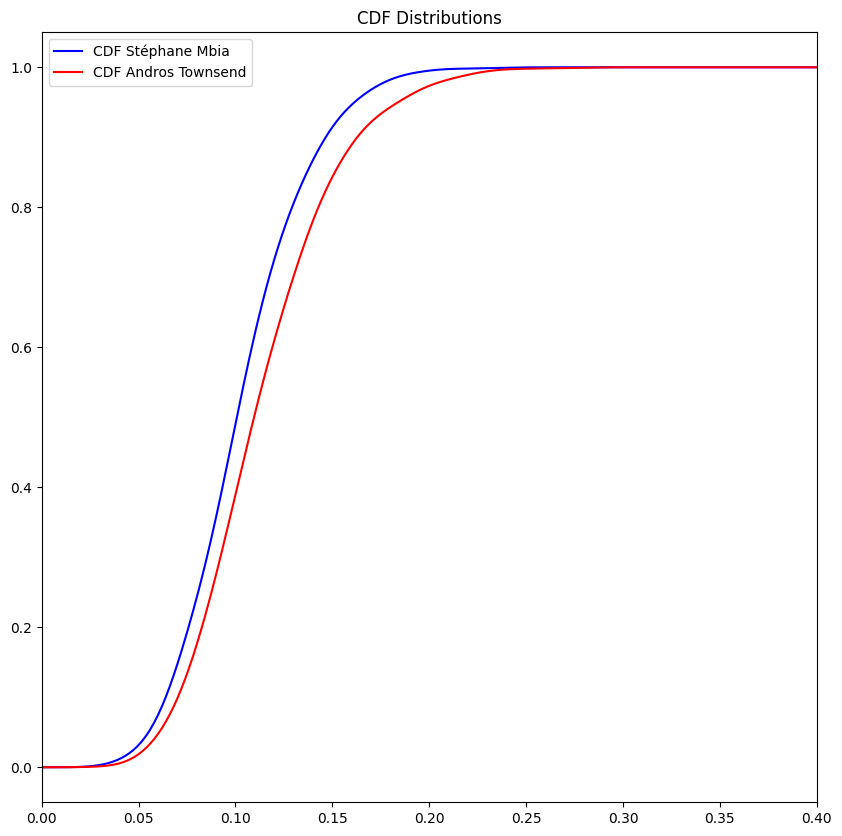

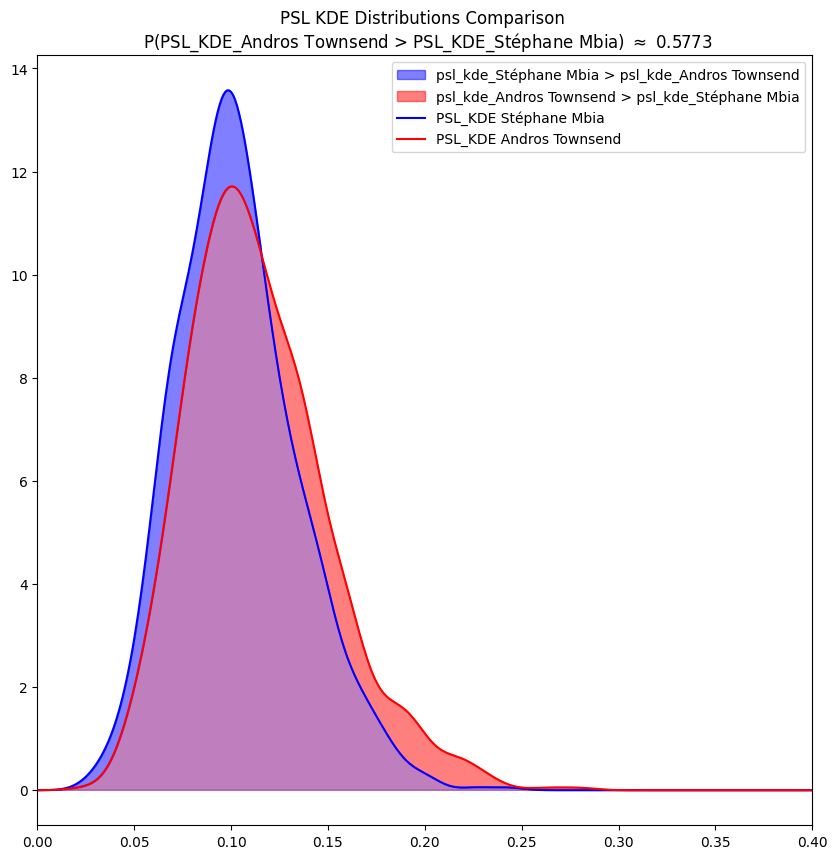

|                 |    Media |   Varianza |   Desvio Estándar |   Skewness |   Kurtosis |
|:----------------|---------:|-----------:|------------------:|-----------:|-----------:|
| Stéphane Mbia   | 0.103317 |  0.0313768 |       0.000984501 |   0.538032 |   0.469288 |
| Andros Townsend | 0.114015 |  0.0362765 |       0.00131599  |   0.764675 |   0.852754 |

\begin{tabular}{lrrrrr}
\toprule
{} &     Media &  Varianza &  Desvio Estándar &  Skewness &  Kurtosis \\
\midrule
Stéphane Mbia   &  0.103317 &  0.031377 &         0.000985 &  0.538032 &  0.469288 \\
Andros Townsend &  0.114015 &  0.036277 &         0.001316 &  0.764675 &  0.852754 \\
\bottomrule
\end{tabular}



100%|██████████| 1000/1000 [00:55<00:00, 17.91it/s]


Finding replacement for player with same position
Old Player: Adel Taarabt - 39765
Old Player Position: M
[1216.0, 27671.0, 39765.0, 19928.0, 19196.0, 20488.0, 11278.0, 19718.0, 49806.0, 19053.0, 46998.0]
['D', 'M', 'M', 'G', 'F', 'D', 'D', 'D', 'F', 'D', 'M']


100%|██████████| 1000/1000 [00:53<00:00, 18.62it/s]


Adel Taarabt Andros Townsend


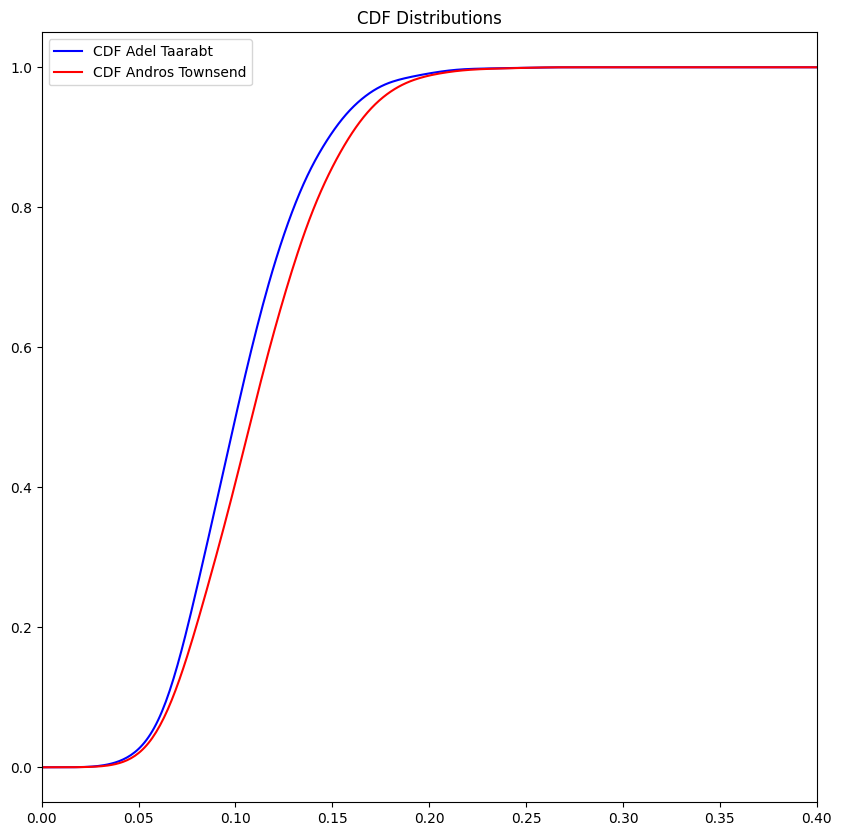

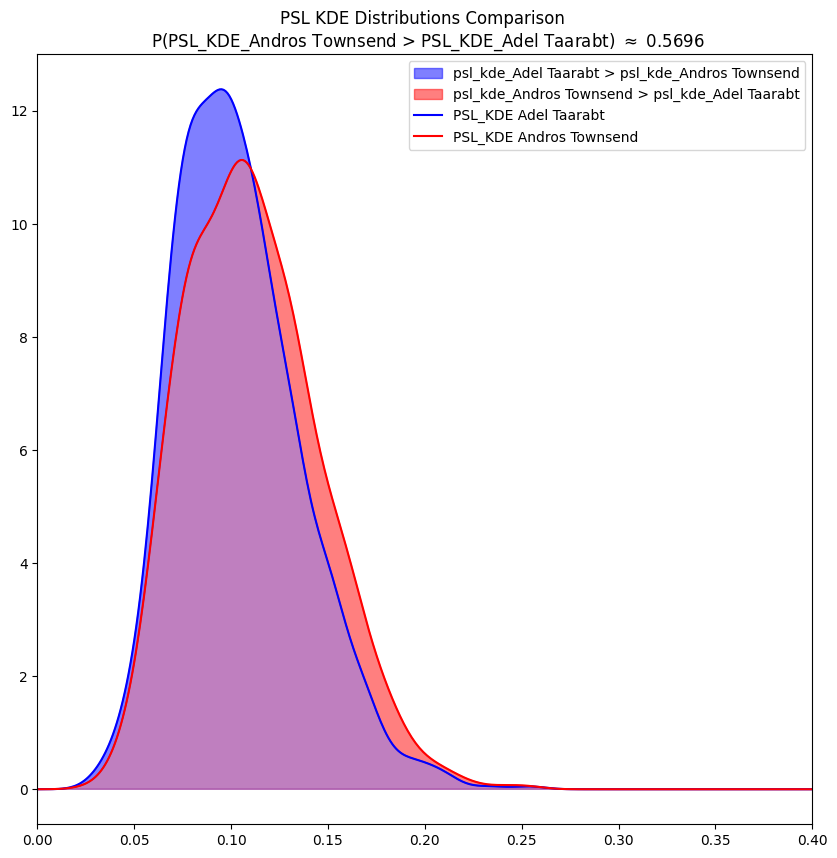

|                 |    Media |   Varianza |   Desvio Estándar |   Skewness |   Kurtosis |
|:----------------|---------:|-----------:|------------------:|-----------:|-----------:|
| Adel Taarabt    | 0.103673 |  0.0321709 |        0.00103496 |   0.706938 |   0.723896 |
| Andros Townsend | 0.111135 |  0.0343047 |        0.00117681 |   0.50452  |   0.143831 |

\begin{tabular}{lrrrrr}
\toprule
{} &     Media &  Varianza &  Desvio Estándar &  Skewness &  Kurtosis \\
\midrule
Adel Taarabt    &  0.103673 &  0.032171 &         0.001035 &  0.706938 &  0.723896 \\
Andros Townsend &  0.111135 &  0.034305 &         0.001177 &  0.504520 &  0.143831 \\
\bottomrule
\end{tabular}



100%|██████████| 1000/1000 [00:53<00:00, 18.61it/s]


Finding replacement for player with same position
Old Player: Esteban Granero - 46998
Old Player Position: M
[1216.0, 27671.0, 39765.0, 19928.0, 19196.0, 20488.0, 11278.0, 19718.0, 49806.0, 19053.0, 46998.0]
['D', 'M', 'M', 'G', 'F', 'D', 'D', 'D', 'F', 'D', 'M']


100%|██████████| 1000/1000 [00:53<00:00, 18.64it/s]


Esteban Granero Andros Townsend


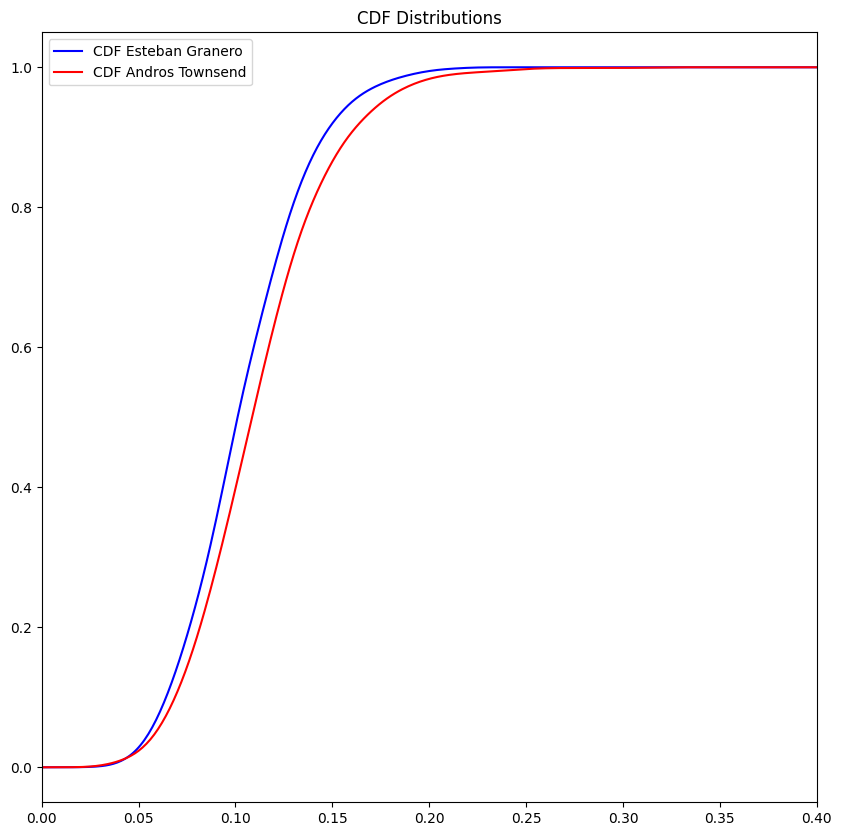

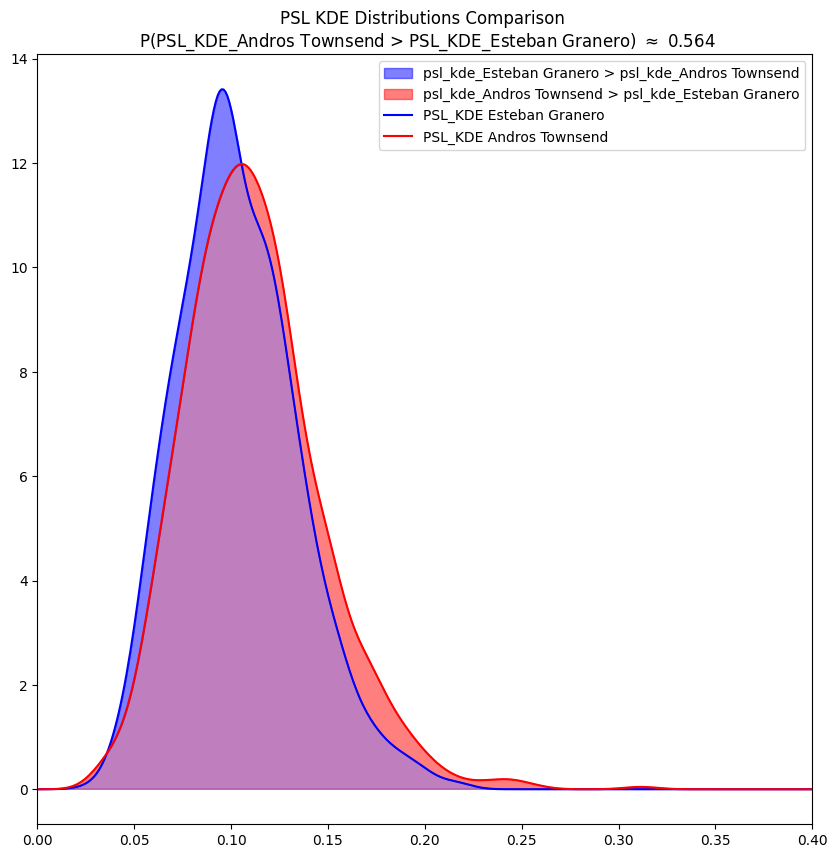

|                 |    Media |   Varianza |   Desvio Estándar |   Skewness |   Kurtosis |
|:----------------|---------:|-----------:|------------------:|-----------:|-----------:|
| Esteban Granero | 0.103651 |  0.0309008 |       0.000954861 |   0.513304 |   0.292514 |
| Andros Townsend | 0.11157  |  0.0349818 |       0.00122373  |   0.782324 |   1.62838  |

\begin{tabular}{lrrrrr}
\toprule
{} &     Media &  Varianza &  Desvio Estándar &  Skewness &  Kurtosis \\
\midrule
Esteban Granero &  0.103651 &  0.030901 &         0.000955 &  0.513304 &  0.292514 \\
Andros Townsend &  0.111570 &  0.034982 &         0.001224 &  0.782324 &  1.628376 \\
\bottomrule
\end{tabular}



In [17]:
psl_mbia, psl_townsend = compare_players("Queens Park Rangers", "Stéphane Mbia", "Andros Townsend", 1000)
psl_taarabt, psl_townsend = compare_players("Queens Park Rangers", "Adel Taarabt", "Andros Townsend", 1000)
psl_granero, psl_townsend = compare_players("Queens Park Rangers", "Esteban Granero", "Andros Townsend", 1000)

## Danny Welbeck

In [18]:
#Danny Welbeck(F, 50175): Manchester United to Arsenal - £16 million (September 2014)
#Compare with Theo Walcott F 20467, Olivier Giroud F 44346
#Arsneal
team_psl_Ars = TeamPSL(EPL_Full_Data)
team_psl_Ars.set_team("Arsenal")
arsenal = team_psl_Ars.calculate_top_11_players()
for i in arsenal:
    print(EPL_Full_Data.get_epl_player_data().get_player_name(i), EPL_Full_Data.get_epl_player_data().get_player_position(i), i)

print(EPL_Full_Data.get_epl_player_data().get_player_id_by_name("Danny Welbeck"))


Mikel Arteta M 8758.0
Santi Cazorla M 19524.0
Per Mertesacker D 17127.0
Olivier Giroud F 44346.0
Aaron Ramsey M 41792.0
Thomas Vermaelen D 15943.0
Bacary Sagna D 37748.0
Wojciech Szczesny G 59936.0
Kieran Gibbs D 42427.0
Theo Walcott F 20467.0
Laurent Koscielny D 51507.0
50175


100%|██████████| 1000/1000 [00:53<00:00, 18.54it/s]


Finding replacement for player with same position
Old Player: Theo Walcott - 20467
Old Player Position: F
[8758.0, 19524.0, 17127.0, 44346.0, 41792.0, 15943.0, 37748.0, 59936.0, 42427.0, 20467.0, 51507.0]
['M', 'M', 'D', 'F', 'M', 'D', 'D', 'G', 'D', 'F', 'D']


100%|██████████| 1000/1000 [00:53<00:00, 18.59it/s]


Theo Walcott Danny Welbeck


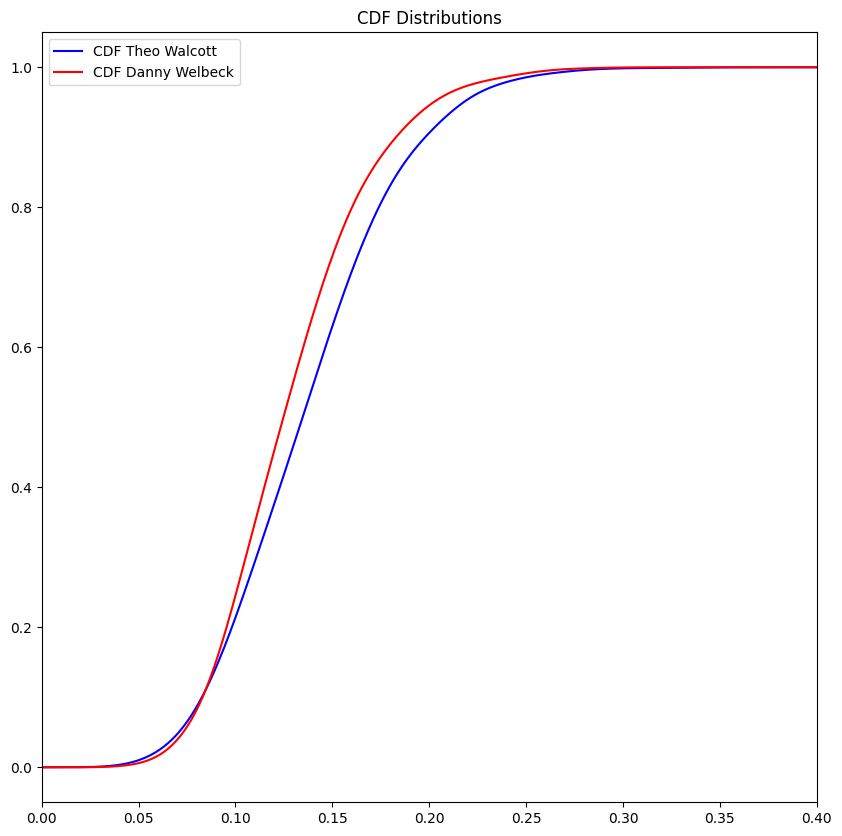

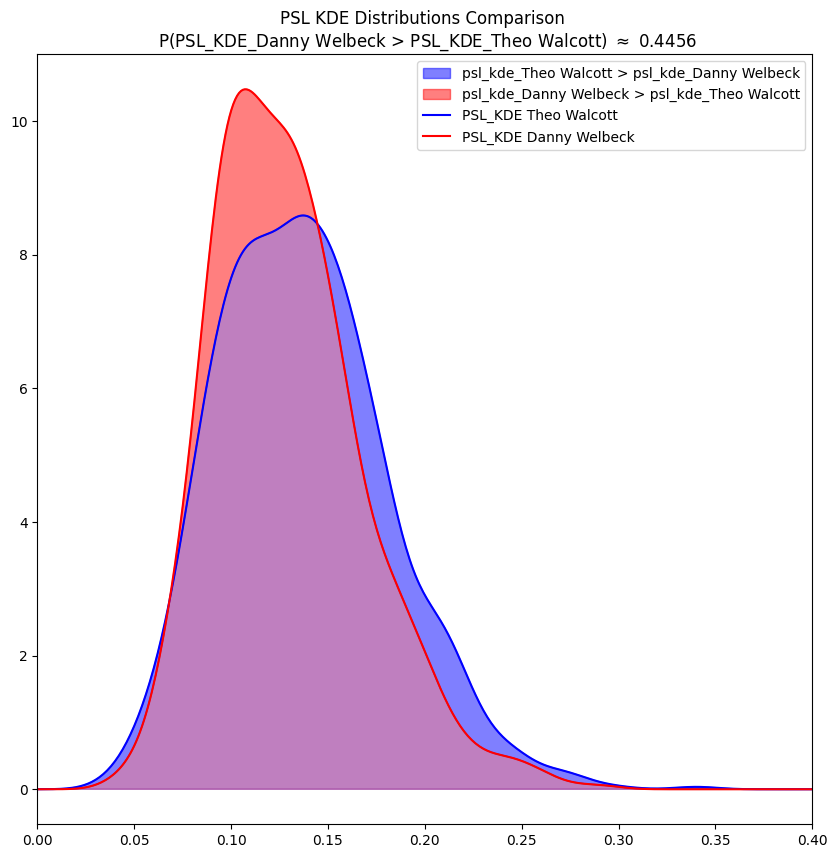

|               |    Media |   Varianza |   Desvio Estándar |   Skewness |   Kurtosis |
|:--------------|---------:|-----------:|------------------:|-----------:|-----------:|
| Theo Walcott  | 0.137735 |  0.0439141 |        0.00192844 |   0.547502 |   0.42181  |
| Danny Welbeck | 0.129325 |  0.0388149 |        0.0015066  |   0.76112  |   0.773602 |

\begin{tabular}{lrrrrr}
\toprule
{} &     Media &  Varianza &  Desvio Estándar &  Skewness &  Kurtosis \\
\midrule
Theo Walcott  &  0.137735 &  0.043914 &         0.001928 &  0.547502 &  0.421810 \\
Danny Welbeck &  0.129325 &  0.038815 &         0.001507 &  0.761120 &  0.773602 \\
\bottomrule
\end{tabular}



100%|██████████| 1000/1000 [00:53<00:00, 18.60it/s]


Finding replacement for player with same position
Old Player: Olivier Giroud - 44346
Old Player Position: F
[8758.0, 19524.0, 17127.0, 44346.0, 41792.0, 15943.0, 37748.0, 59936.0, 42427.0, 20467.0, 51507.0]
['M', 'M', 'D', 'F', 'M', 'D', 'D', 'G', 'D', 'F', 'D']


100%|██████████| 1000/1000 [00:53<00:00, 18.59it/s]


Olivier Giroud Danny Welbeck


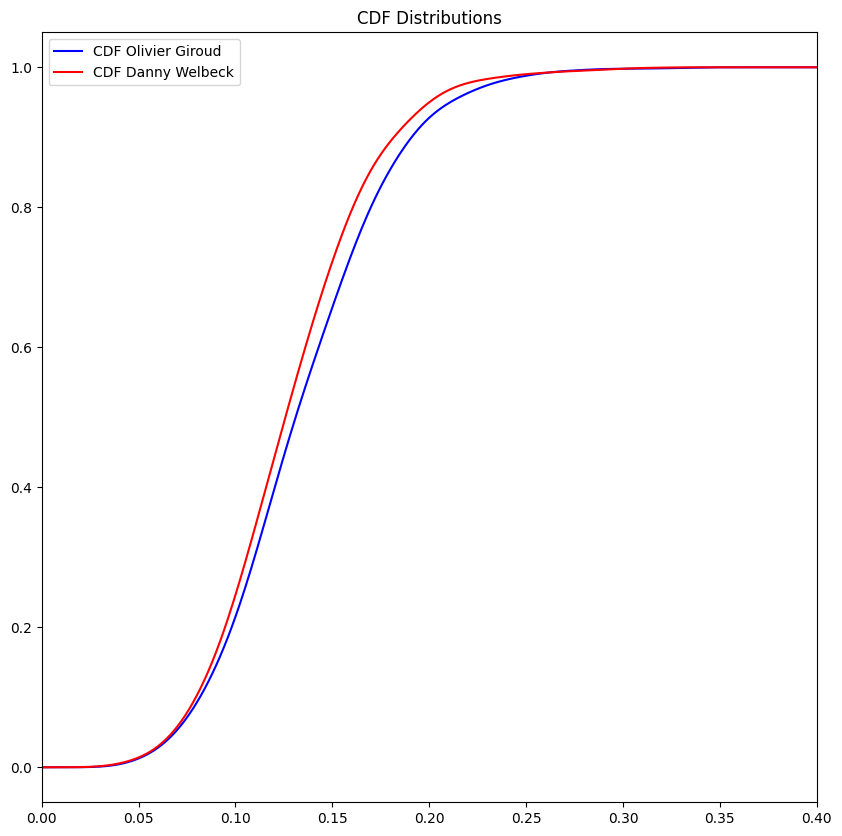

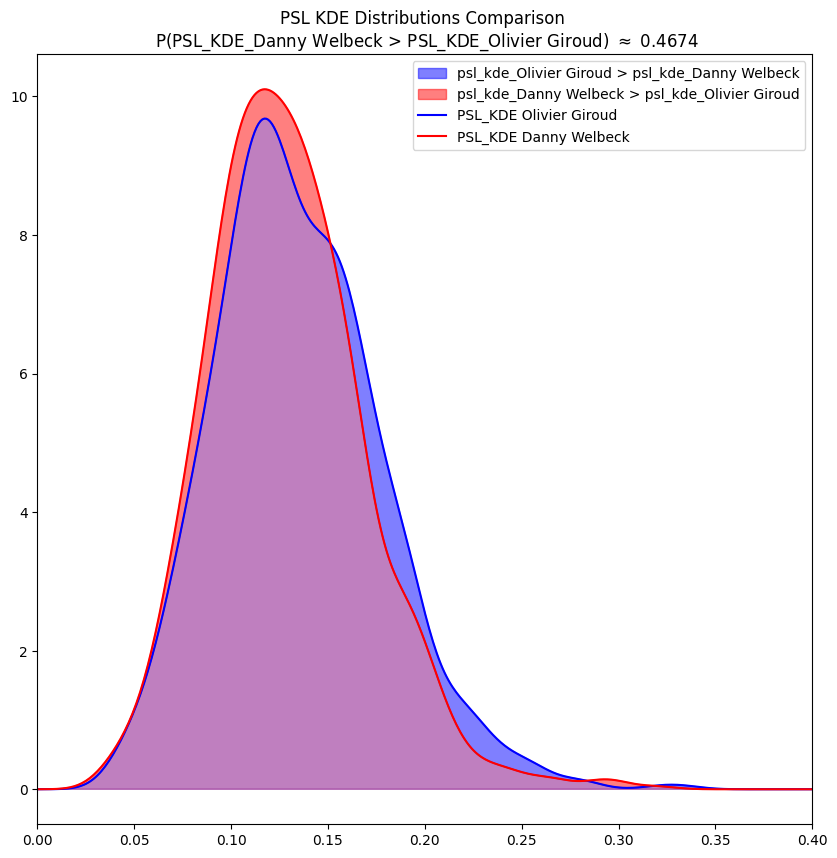

|                |    Media |   Varianza |   Desvio Estándar |   Skewness |   Kurtosis |
|:---------------|---------:|-----------:|------------------:|-----------:|-----------:|
| Olivier Giroud | 0.134801 |  0.0425351 |        0.00180924 |   0.587343 |   0.777267 |
| Danny Welbeck  | 0.128931 |  0.0401304 |        0.00161045 |   0.70055  |   1.32506  |

\begin{tabular}{lrrrrr}
\toprule
{} &     Media &  Varianza &  Desvio Estándar &  Skewness &  Kurtosis \\
\midrule
Olivier Giroud &  0.134801 &  0.042535 &         0.001809 &  0.587343 &  0.777267 \\
Danny Welbeck  &  0.128931 &  0.040130 &         0.001610 &  0.700550 &  1.325063 \\
\bottomrule
\end{tabular}



In [19]:
psl_walcott, psl_welbeck = compare_players("Arsenal", "Theo Walcott", "Danny Welbeck", 1000)
psl_giroud, psl_welbeck = compare_players("Arsenal", "Olivier Giroud", "Danny Welbeck", 1000)

## Wilfried Bony

In [11]:
#Wilfried Bony(F, 50175): Swansea City to Manchester City - £28 million (January 2015)
#Compare with Edin Dzeko F 42544, Sergio Agüero F 37572
#Manchester city

team_psl_manC = TeamPSL(EPL_Full_Data)
team_psl_manC.set_team("Manchester City")
manC = team_psl_manC.calculate_top_11_players()
for i in manC:
    print(EPL_Full_Data.get_epl_player_data().get_player_name(i), EPL_Full_Data.get_epl_player_data().get_player_position(i), i)

print(EPL_Full_Data.get_epl_player_data().get_player_id_by_name("Wilfried Bony"), 'No existe')
print(EPL_Full_Data.get_epl_player_data().get_player_position())


Joe Hart G 15749.0
Yaya Touré M 14664.0
Pablo Zabaleta D 20658.0
Gareth Barry M 1632.0
Gaël Clichy D 17336.0
Vincent Kompany D 17476.0
Edin Dzeko F 42544.0
David Silva M 20664.0
Carlos Tevez F 20312.0
Joleon Lescott D 7551.0
Sergio Agüero F 37572.0
None No existe


TypeError: EPLPlayerData.get_player_position() missing 1 required positional argument: 'player_opta_id'

In [ ]:
psl_dzeko, psl_bony = compare_players("Manchester City", "Edin Dzeko", "Wilfried Bony", 1000)
psl_aguero, psl_bony = compare_players("Manchester City", "Sergio Agüero", "Wilfried Bony", 1000)

## Ryan Bertrand

In [20]:
# Ryan Bertrand(40146, D): Chelsea to Southampton - Loan, later permanent transfer (January 2015)
#Compare with Luke Shaw D 106760, Jos Hooiveld D 15976, Nathaniel Clyne D 57328 and Maya Yoshida D 80447
#Southampton

team_psl_SOU = TeamPSL(EPL_Full_Data)
team_psl_SOU.set_team("Southampton")
southampton = team_psl_SOU.calculate_top_11_players()
for i in southampton:
    print(EPL_Full_Data.get_epl_player_data().get_player_name(i), EPL_Full_Data.get_epl_player_data().get_player_position(i), i)

print(EPL_Full_Data.get_epl_player_data().get_player_id_by_name("Ryan Bertrand"))
print(EPL_Full_Data.get_epl_player_data().get_player_position(40146))

Morgan Schneiderlin M 42774.0
Nathaniel Clyne D 57328.0
Maya Yoshida D 80447.0
Rickie Lambert F 11037.0
José Fonte D 38580.0
Jack Cork M 40145.0
Jay Rodriguez F 44683.0
Jos Hooiveld D 15976.0
None None 17339.0
Adam Lallana M 39155.0
Luke Shaw D 106760.0
40146
D


100%|██████████| 1000/1000 [00:53<00:00, 18.55it/s]


Finding replacement for player with same position
Old Player: Luke Shaw - 106760
Old Player Position: D
[42774.0, 57328.0, 80447.0, 11037.0, 38580.0, 40145.0, 44683.0, 15976.0, 17339.0, 39155.0, 106760.0]
['M', 'D', 'D', 'F', 'D', 'M', 'F', 'D', None, 'M', 'D']


100%|██████████| 1000/1000 [00:53<00:00, 18.58it/s]


Luke Shaw Ryan Bertrand


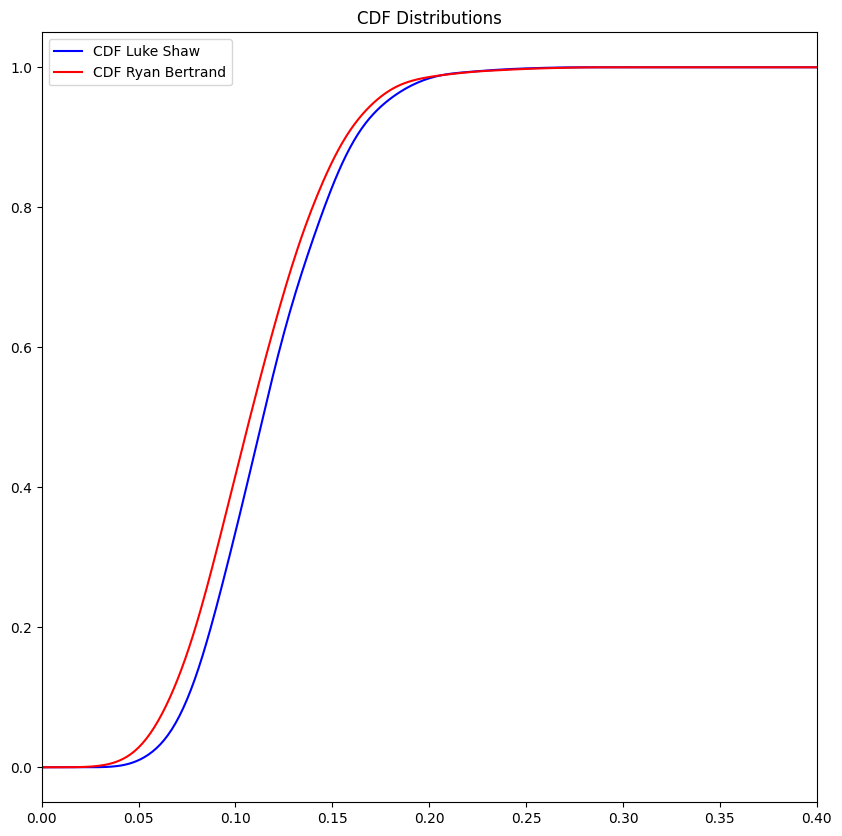

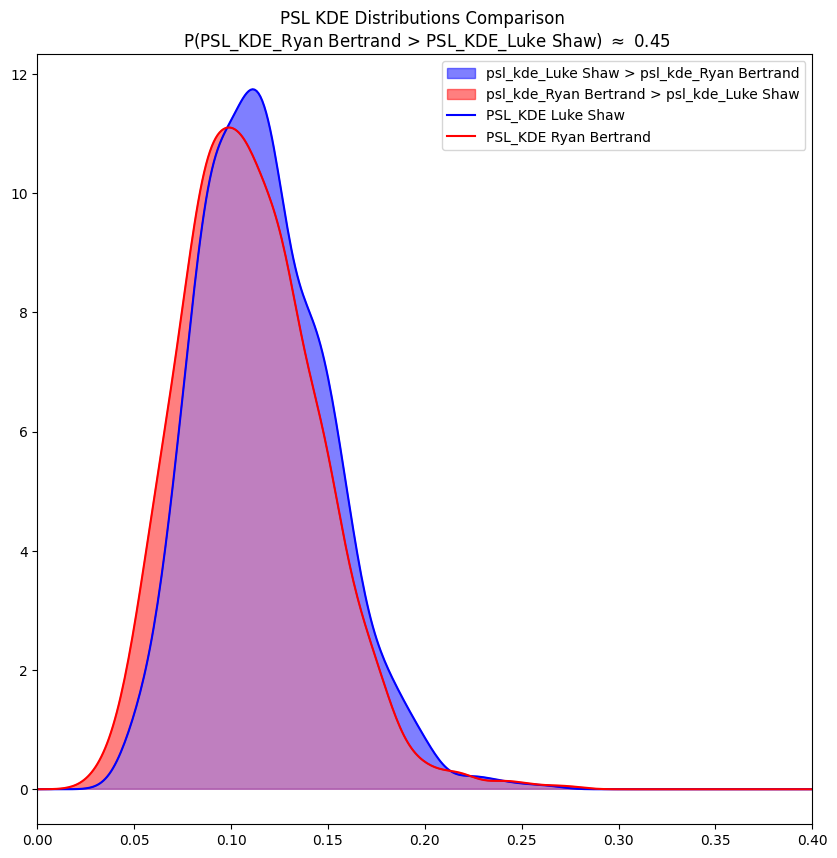

|               |    Media |   Varianza |   Desvio Estándar |   Skewness |   Kurtosis |
|:--------------|---------:|-----------:|------------------:|-----------:|-----------:|
| Luke Shaw     | 0.117174 |  0.0335192 |        0.00112354 |    0.57392 |   0.50319  |
| Ryan Bertrand | 0.110293 |  0.0349705 |        0.00122294 |    0.60097 |   0.795506 |

\begin{tabular}{lrrrrr}
\toprule
{} &     Media &  Varianza &  Desvio Estándar &  Skewness &  Kurtosis \\
\midrule
Luke Shaw     &  0.117174 &  0.033519 &         0.001124 &   0.57392 &  0.503190 \\
Ryan Bertrand &  0.110293 &  0.034971 &         0.001223 &   0.60097 &  0.795506 \\
\bottomrule
\end{tabular}



100%|██████████| 1000/1000 [00:53<00:00, 18.63it/s]


Finding replacement for player with same position
Old Player: Jos Hooiveld - 15976
Old Player Position: D
[42774.0, 57328.0, 80447.0, 11037.0, 38580.0, 40145.0, 44683.0, 15976.0, 17339.0, 39155.0, 106760.0]
['M', 'D', 'D', 'F', 'D', 'M', 'F', 'D', None, 'M', 'D']


100%|██████████| 1000/1000 [00:53<00:00, 18.69it/s]


Jos Hooiveld Ryan Bertrand


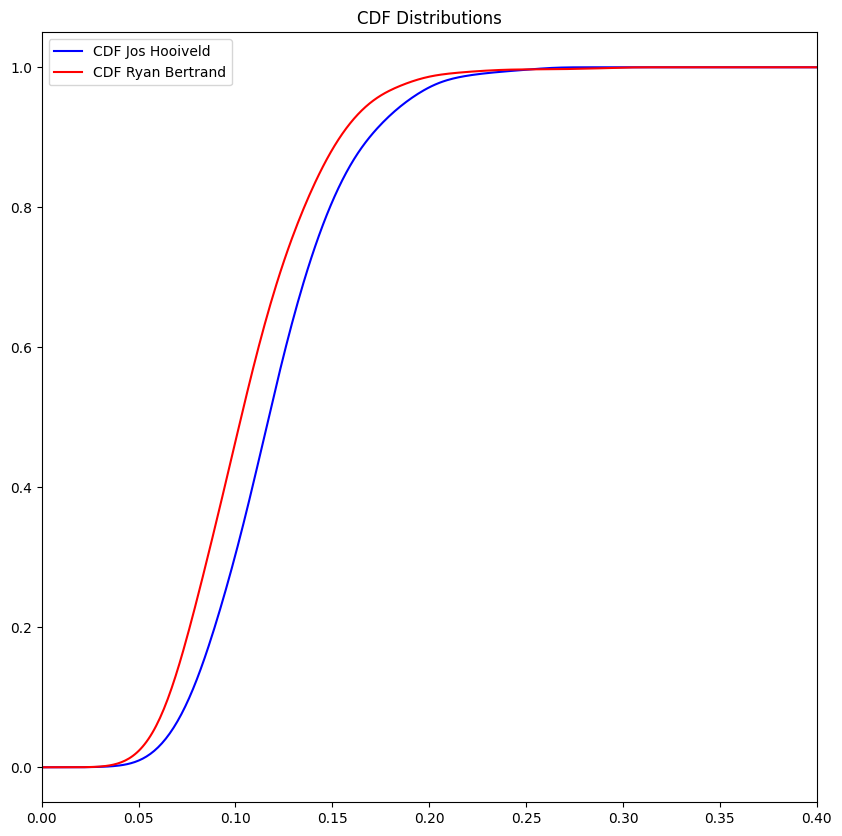

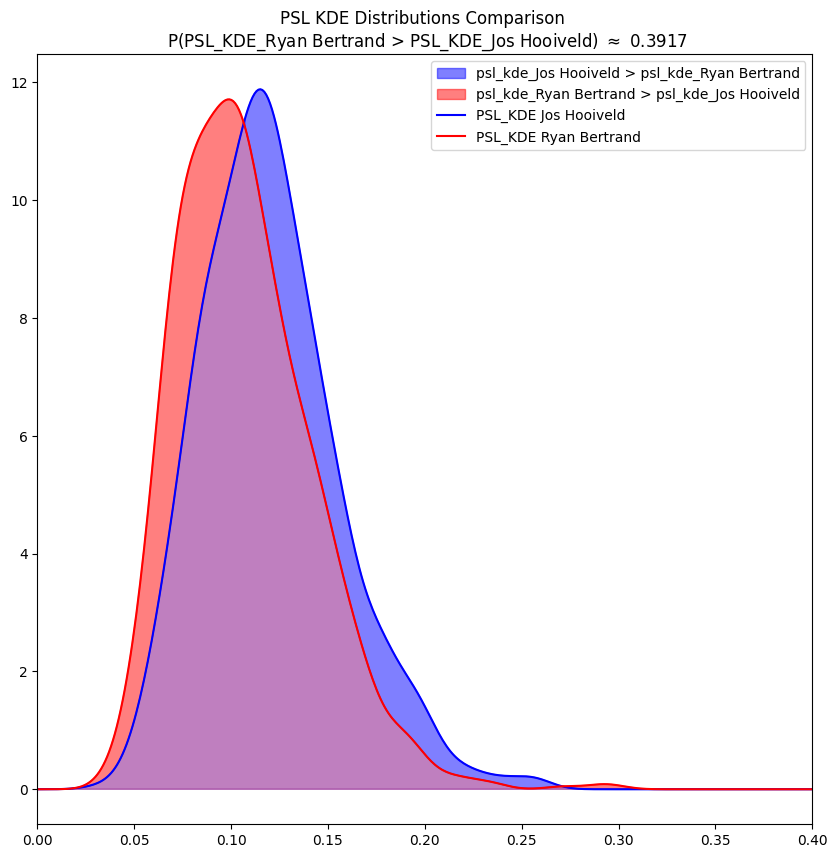

|               |    Media |   Varianza |   Desvio Estándar |   Skewness |   Kurtosis |
|:--------------|---------:|-----------:|------------------:|-----------:|-----------:|
| Jos Hooiveld  | 0.120496 |  0.0357134 |        0.00127545 |   0.670637 |   0.700236 |
| Ryan Bertrand | 0.107116 |  0.0347917 |        0.00121046 |   0.942766 |   1.91752  |

\begin{tabular}{lrrrrr}
\toprule
{} &     Media &  Varianza &  Desvio Estándar &  Skewness &  Kurtosis \\
\midrule
Jos Hooiveld  &  0.120496 &  0.035713 &         0.001275 &  0.670637 &  0.700236 \\
Ryan Bertrand &  0.107116 &  0.034792 &         0.001210 &  0.942766 &  1.917516 \\
\bottomrule
\end{tabular}



100%|██████████| 1000/1000 [00:53<00:00, 18.57it/s]


Finding replacement for player with same position
Old Player: Nathaniel Clyne - 57328
Old Player Position: D
[42774.0, 57328.0, 80447.0, 11037.0, 38580.0, 40145.0, 44683.0, 15976.0, 17339.0, 39155.0, 106760.0]
['M', 'D', 'D', 'F', 'D', 'M', 'F', 'D', None, 'M', 'D']


100%|██████████| 1000/1000 [00:54<00:00, 18.41it/s]


Nathaniel Clyne Ryan Bertrand


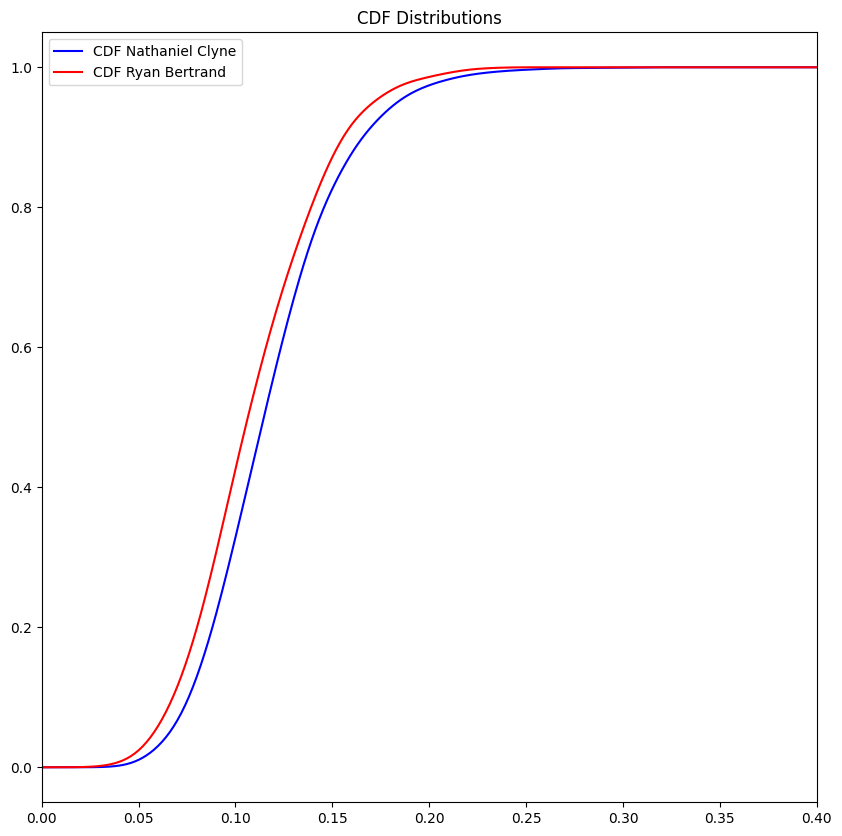

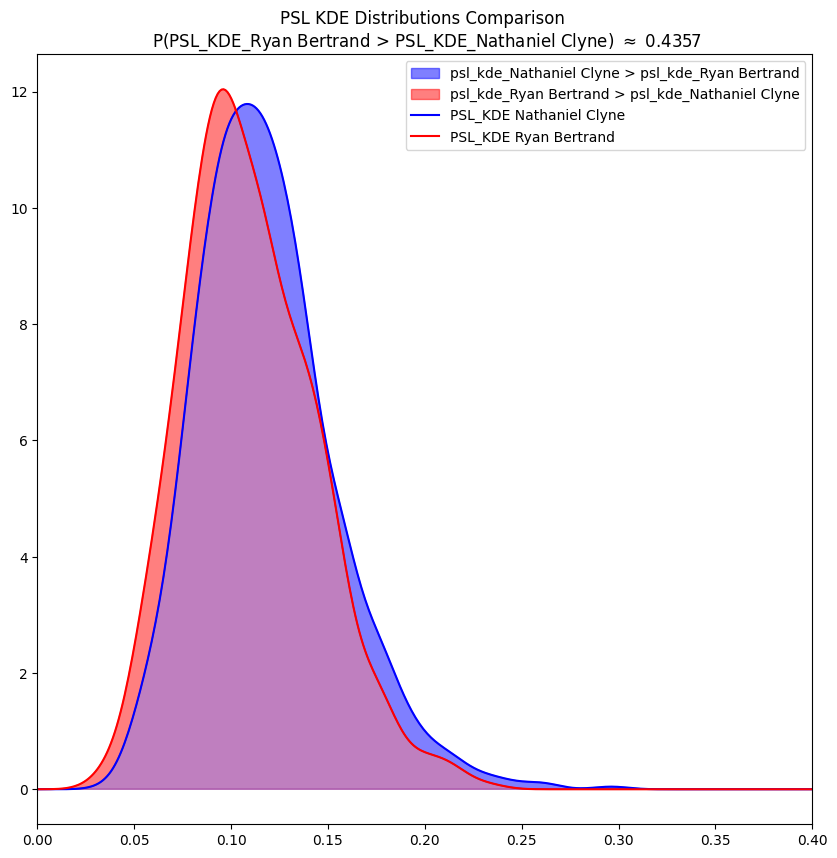

|                 |    Media |   Varianza |   Desvio Estándar |   Skewness |   Kurtosis |
|:----------------|---------:|-----------:|------------------:|-----------:|-----------:|
| Nathaniel Clyne | 0.118319 |  0.0351874 |        0.00123815 |   0.801457 |   1.26599  |
| Ryan Bertrand   | 0.109854 |  0.0338036 |        0.00114268 |   0.52864  |   0.235604 |

\begin{tabular}{lrrrrr}
\toprule
{} &     Media &  Varianza &  Desvio Estándar &  Skewness &  Kurtosis \\
\midrule
Nathaniel Clyne &  0.118319 &  0.035187 &         0.001238 &  0.801457 &  1.265995 \\
Ryan Bertrand   &  0.109854 &  0.033804 &         0.001143 &  0.528640 &  0.235604 \\
\bottomrule
\end{tabular}



100%|██████████| 1000/1000 [00:53<00:00, 18.67it/s]


Finding replacement for player with same position
Old Player: Maya Yoshida - 80447
Old Player Position: D
[42774.0, 57328.0, 80447.0, 11037.0, 38580.0, 40145.0, 44683.0, 15976.0, 17339.0, 39155.0, 106760.0]
['M', 'D', 'D', 'F', 'D', 'M', 'F', 'D', None, 'M', 'D']


100%|██████████| 1000/1000 [00:53<00:00, 18.58it/s]


Maya Yoshida Ryan Bertrand


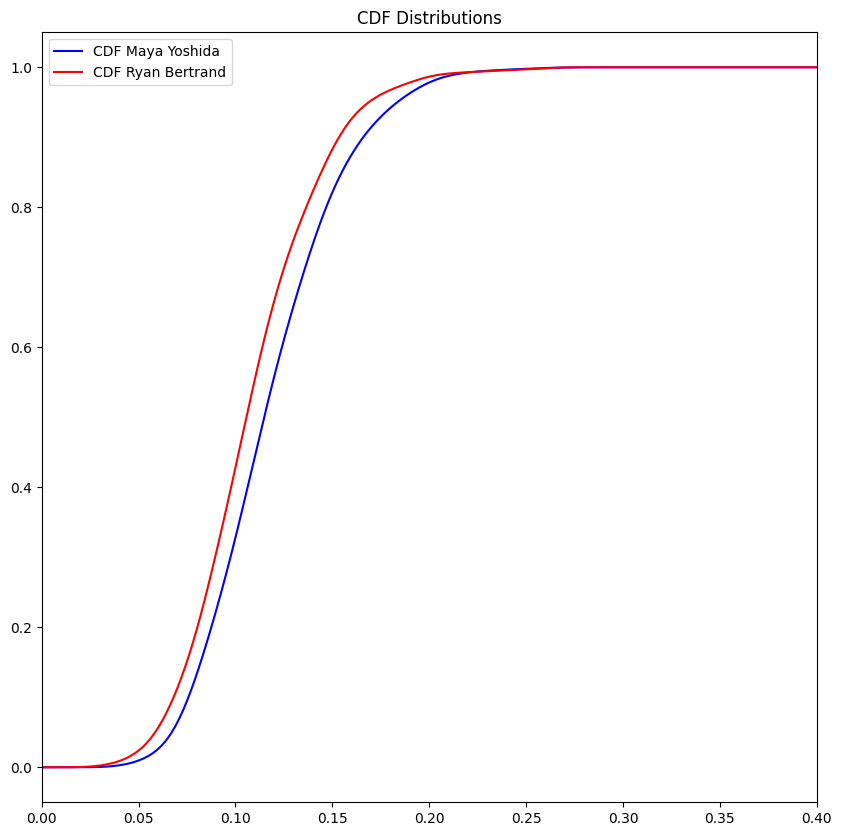

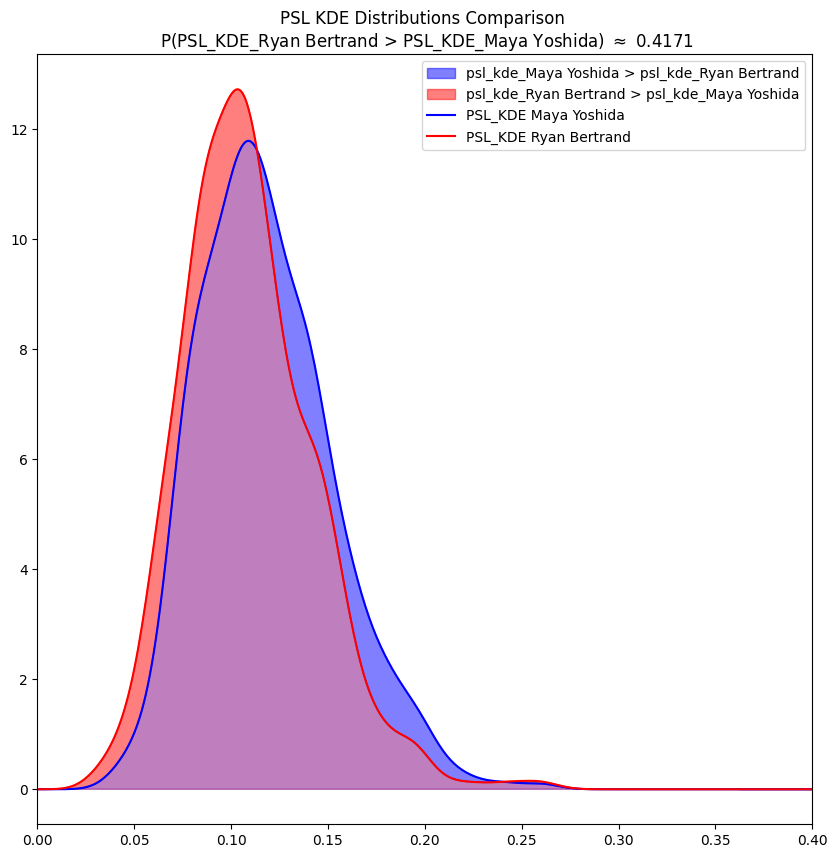

|               |    Media |   Varianza |   Desvio Estándar |   Skewness |   Kurtosis |
|:--------------|---------:|-----------:|------------------:|-----------:|-----------:|
| Maya Yoshida  | 0.118391 |  0.0345973 |        0.00119697 |   0.63599  |   0.520684 |
| Ryan Bertrand | 0.109027 |  0.0336853 |        0.0011347  |   0.765011 |   1.37136  |

\begin{tabular}{lrrrrr}
\toprule
{} &     Media &  Varianza &  Desvio Estándar &  Skewness &  Kurtosis \\
\midrule
Maya Yoshida  &  0.118391 &  0.034597 &         0.001197 &  0.635990 &  0.520684 \\
Ryan Bertrand &  0.109027 &  0.033685 &         0.001135 &  0.765011 &  1.371355 \\
\bottomrule
\end{tabular}



In [21]:
psl_bertrand, psl_shaw = compare_players("Southampton", "Luke Shaw", "Ryan Bertrand", 1000)
psl_hooiveld, psl_bertrand = compare_players("Southampton", "Jos Hooiveld", "Ryan Bertrand", 1000)
psl_clyne, psl_bertrand = compare_players("Southampton", "Nathaniel Clyne", "Ryan Bertrand", 1000)
psl_yoshida, psl_bertrand = compare_players("Southampton", "Maya Yoshida", "Ryan Bertrand", 1000)

In [ ]:
# James Milner(15157, M): City to Liverpool 
#Compare with Steven Gerrard M 1814.0, Stewart Downing M 12002.0


team_psl_liver = TeamPSL(EPL_Full_Data)
team_psl_liver.set_team("Liverpool")
liverpool = team_psl_liver.calculate_top_11_players()
for i in liverpool:
    print(EPL_Full_Data.get_epl_player_data().get_player_name(i), EPL_Full_Data.get_epl_player_data().get_player_position(i), i)

print(EPL_Full_Data.get_epl_player_data().get_player_id_by_name("James Milner"))

None None 9047.0
Steven Gerrard M 1814.0
Daniel Agger D 21094.0
Luis Suárez F 39336.0
Pepe Reina G 8432.0
José Enrique D 26725.0
Martin Skrtel D 26793.0
Stewart Downing M 12002.0
Joe Allen M 40555.0
Jamie Carragher D 1809.0
Raheem Sterling F 103955.0
15157


100%|██████████| 1000/1000 [00:55<00:00, 17.94it/s]


Finding replacement for player with same position
Old Player: Steven Gerrard - 1814
Old Player Position: M
[9047.0, 1814.0, 21094.0, 39336.0, 8432.0, 26725.0, 26793.0, 12002.0, 40555.0, 1809.0, 103955.0]
[None, 'M', 'D', 'F', 'G', 'D', 'D', 'M', 'M', 'D', 'F']


100%|██████████| 1000/1000 [00:54<00:00, 18.31it/s]


Steven Gerrard James Milner


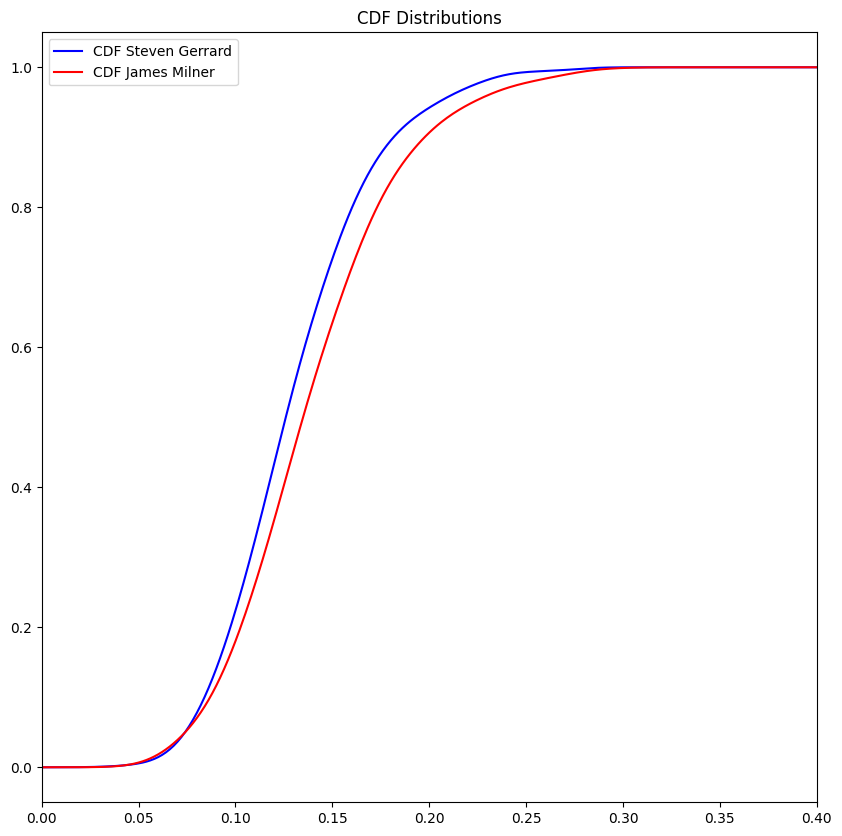

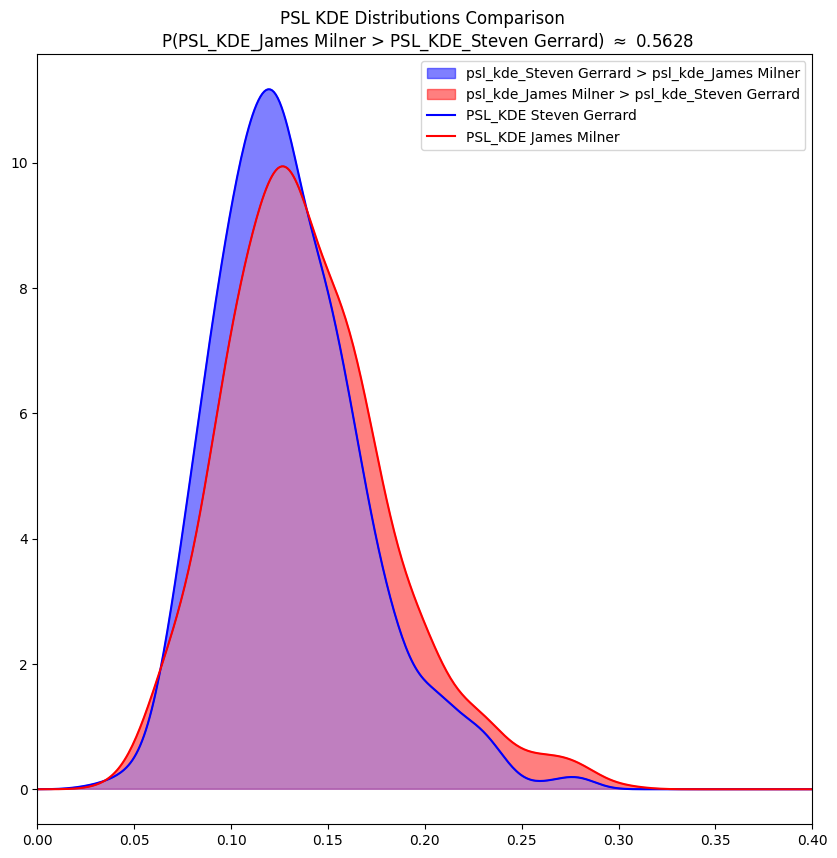

|                |    Media |   Varianza |   Desvio Estándar |   Skewness |   Kurtosis |
|:---------------|---------:|-----------:|------------------:|-----------:|-----------:|
| Steven Gerrard | 0.130349 |  0.0382904 |        0.00146615 |   0.748219 |   0.862186 |
| James Milner   | 0.139559 |  0.0433331 |        0.00187775 |   0.703642 |   0.712261 |

\begin{tabular}{lrrrrr}
\toprule
{} &     Media &  Varianza &  Desvio Estándar &  Skewness &  Kurtosis \\
\midrule
Steven Gerrard &  0.130349 &  0.038290 &         0.001466 &  0.748219 &  0.862186 \\
James Milner   &  0.139559 &  0.043333 &         0.001878 &  0.703642 &  0.712261 \\
\bottomrule
\end{tabular}



100%|██████████| 1000/1000 [00:54<00:00, 18.30it/s]


Finding replacement for player with same position
Old Player: Stewart Downing - 12002
Old Player Position: M
[42774.0, 57328.0, 80447.0, 11037.0, 38580.0, 40145.0, 44683.0, 15976.0, 17339.0, 39155.0, 106760.0]
['M', 'D', 'D', 'F', 'D', 'M', 'F', 'D', None, 'M', 'D']


100%|██████████| 1000/1000 [00:55<00:00, 17.95it/s]


Stewart Downing James Milner


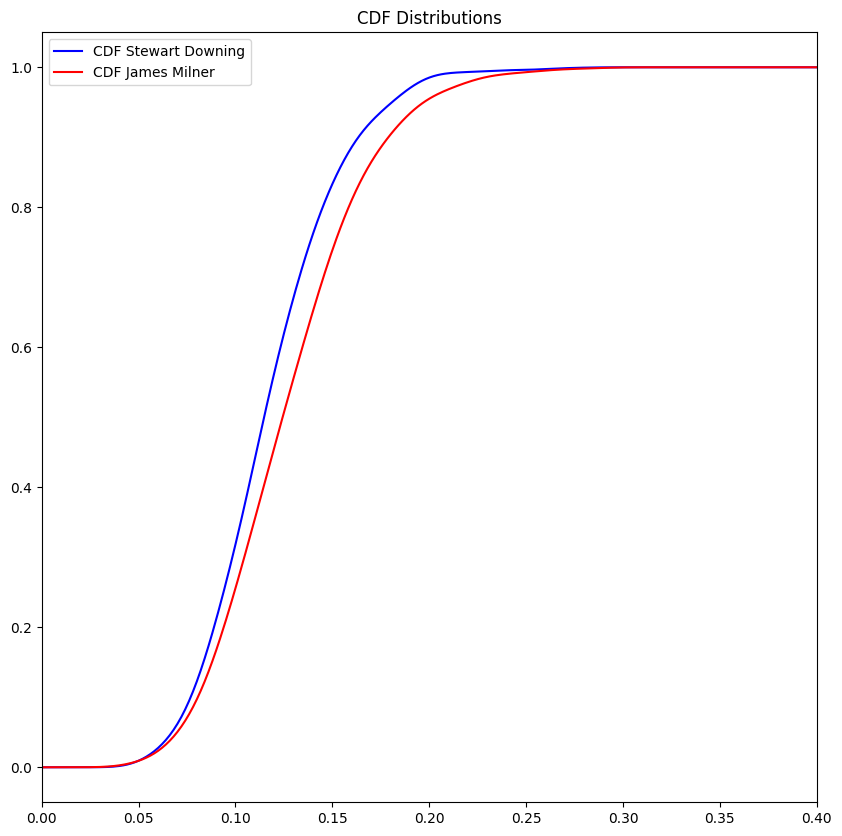

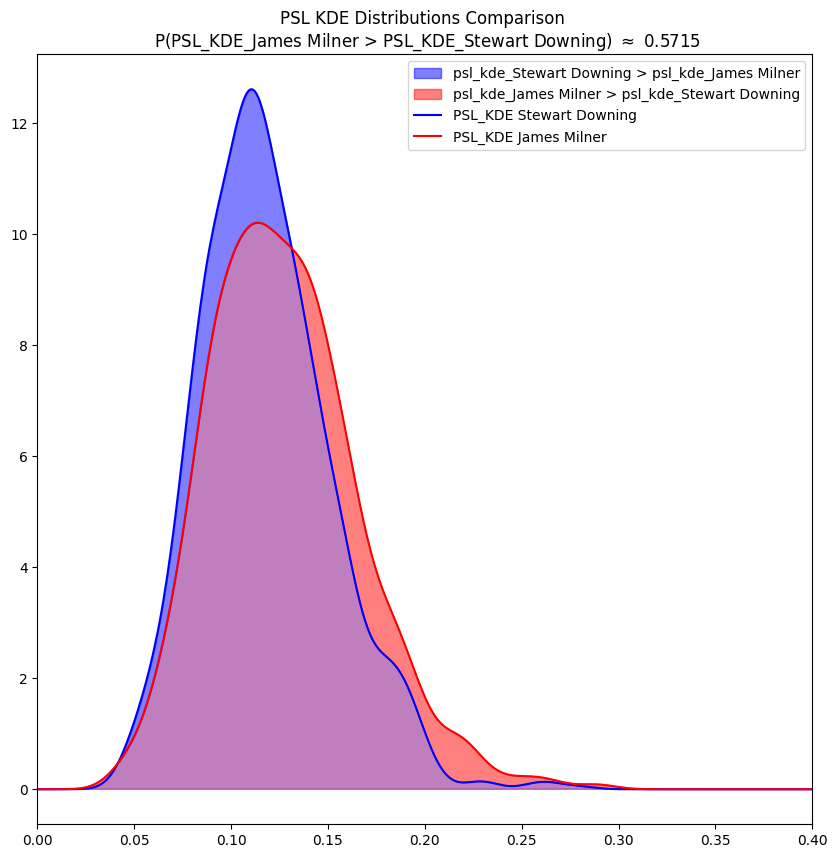

|                 |    Media |   Varianza |   Desvio Estándar |   Skewness |   Kurtosis |
|:----------------|---------:|-----------:|------------------:|-----------:|-----------:|
| Stewart Downing | 0.117987 |  0.0335177 |        0.00112343 |   0.696171 |   1.087    |
| James Milner    | 0.127622 |  0.038303  |        0.00146712 |   0.651483 |   0.768572 |

\begin{tabular}{lrrrrr}
\toprule
{} &     Media &  Varianza &  Desvio Estándar &  Skewness &  Kurtosis \\
\midrule
Stewart Downing &  0.117987 &  0.033518 &         0.001123 &  0.696171 &  1.087000 \\
James Milner    &  0.127622 &  0.038303 &         0.001467 &  0.651483 &  0.768572 \\
\bottomrule
\end{tabular}



In [26]:
psl_gerrard, psl_milner = compare_players("Liverpool", "Steven Gerrard", "James Milner", 1000)
psl_downning, psl_milner1 = compare_players("Southampton", "Stewart Downing", "James Milner", 1000)

(0.0, 0.35)

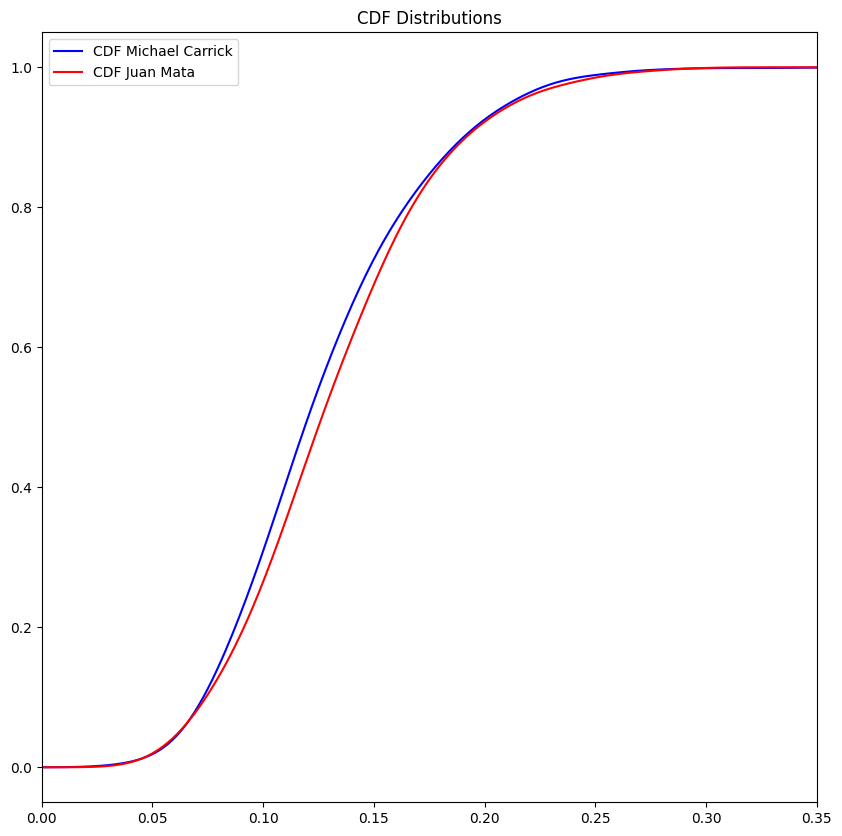

In [70]:
fig, ax = plt.subplots(figsize=(10, 10))

plot_psl_cdfs(psl_carrick, psl_mata, ax=ax, names=["Michael Carrick", "Juan Mata"], colors=["b", "r"])

ax.set_xlim(0, 0.35)

In [47]:
from src.Player2Vec import Player2Vec, EPL_Graph

In [48]:
EPL_Full_Data

EPL_Data(../SampleData/epl.xlsx, ../SampleData/players.json, R_storage.npy) 
380 Partidos 
522 Jugadores

In [49]:
epl_graph = EPL_Graph(EPL_Full_Data)

In [57]:
# Count nodes and edges of epl_graph.graph, .graph is a networkx digraph

# epl_graph.graph.number_of_nodes(), epl_graph.graph.number_of_edges()

print("#Vertices: ", epl_graph.graph.number_of_nodes())
print("#Edges: ", epl_graph.graph.number_of_edges())

#Vertices:  37521
#Edges:  47338


In [55]:
epl_graph.load_graph("EPL_Graph_R_Weighted.pkl")

In [29]:
_ = epl_graph.build_graph(use_Q=True, weight_player_to_state=True)

Building Graph: 100%|██████████| 2795/2795 [14:49<00:00,  3.14it/s]


In [ ]:
for u, v, w in epl_graph.graph.edges(data=True):
    print(w)

In [30]:
for u, v, d in epl_graph.graph.edges(data=True):
    if "weight" not in d:
        print(u, v, d)

In [ ]:
total_w = sum(
    [d["weight"] for _, _, d in epl_graph.graph.edges(data=True) if "weight" in d]
)

In [24]:
import numpy as np

In [27]:
for u, v, d in epl_graph.graph.edges(data=True):
    if "weight" in d:
        if not np.isfinite(d["weight"] / total_w):
            print(u, v, d["weight"], d["weight"] / total_w)

In [ ]:
p2v_model = Player2Vec(epl_data=EPL_Full_Data)
p2v_model.train(epl_graph.graph, q=0.5)

In [123]:
model_path = "EPL_Graph_model_3_Weight_Duration_Q.model"
# model_path = "EPL_Graph_model_3__R_Weighted.model"
p2v_model = Player2Vec(model_path=model_path, epl_data=EPL_Full_Data)

In [124]:
len(set([p_id.split("_")[0] for p_id in p2v_model.get_ids()]))

525

In [125]:
len([p_id for p_id in p2v_model.get_ids() if "_" not in p_id])

524

In [132]:
def display_similarities(player_name: str, topn=10, same_position=True):
    id_sample_player = p2v_model.epl_player_data.get_player_id_by_name(player_name)
    sample_team = p2v_model.get_team_name(player_name)
    sample_position = p2v_model.epl_player_data.get_player_position(id_sample_player)

    total = len([x for x in p2v_model.get_ids()])

    most_similar = p2v_model.model.wv.most_similar(f"{id_sample_player}___", topn=total)
    count = 0
    for player_id, similarity in most_similar:
        if player_id.split("_")[0] in ["Gain", "Loss", "Shot"]:
            continue
        if count == topn:
            break
        # if "_" in player_id and "___" not in player_id:
            # continue
        if "_" in player_id:
            continue
        player_id = p2v_model.rework_id(player_id)
        player_name = p2v_model.epl_player_data.get_player_name(player_id)
        team = p2v_model.get_team_name(player_id)
        position = p2v_model.epl_player_data.get_player_position(player_id)

        if (
            True
            and (sample_team != team) 
            and (position == sample_position or not same_position)
        ):
            count += 1
            print(f"{player_name} {player_id} ({team}): {similarity} - {position}")


display_similarities("Sergio Agüero")

Magaye Gueye 57835 (Swansea City): 0.9999375343322754 - F
Sammy Ameobi 97612 (Newcastle United): 0.9952880144119263 - F
Apostolos Vellios 60865 (Everton): 0.9924089908599854 - F
Louis Saha 4396 (Arsenal): 0.9734461307525635 - F
Loïc Rémy 38419 (West Ham United): 0.9673224091529846 - F
Luciano Becchio 19791 (Queens Park Rangers): 0.9668170213699341 - F
Shola Ameobi 6240 (Everton): 0.9603272080421448 - F
Michael Owen 1795 (Stoke City): 0.9582937955856323 - F
Romelu Lukaku 66749 (West Bromwich Albion): 0.9410472512245178 - F
Rickie Lambert 11037 (Manchester City): 0.9362635016441345 - F


In [127]:
p2v_model.model.wv.similarity(
    f"{p2v_model.epl_player_data.get_player_id_by_name('Sergio Agüero')}",
    f"{p2v_model.epl_player_data.get_player_id_by_name('Olivier Giroud')}",
)

0.98547244

In [112]:
# Cosine similarity between two players
p2v_model.model.wv.similarity(
    f"{p2v_model.epl_player_data.get_player_id_by_name('Sergio Agüero')}___",
    f"{p2v_model.epl_player_data.get_player_id_by_name('Olivier Giroud')}___",
)
    

0.9863141

In [113]:
similars = p2v_model.get_similar_players("Mario Balotelli", 10)
similars

[('Raheem Sterling', 103955, 'Liverpool', 0.9999727606773376, 'F'),
 ('Magaye Gueye', 57835, 'Swansea City', 0.999930202960968, 'F'),
 ('Demba Ba', 47412, 'Newcastle United', 0.9998716711997986, 'F'),
 ('Lukas Podolski', 17733, 'Arsenal', 0.9996523261070251, 'F'),
 ('Junior Hoilett', 49806, 'Queens Park Rangers', 0.999647319316864, 'F'),
 ('Peter Odemwingie', 26900, 'West Bromwich Albion', 0.999541163444519, 'F'),
 ('Mladen Petric', 11987, 'Fulham', 0.9994903206825256, 'F'),
 ('Carlton Cole', 12799, 'West Ham United', 0.9994598627090454, 'F'),
 ('Shane Long', 20452, 'West Bromwich Albion', 0.9992810487747192, 'F'),
 ('Demba Ba', 47412, 'Newcastle United', 0.9992643594741821, 'F')]

In [67]:
player_comparison.rank_players(
    "Sergio Agüero",
    [s[0] for s in similars],
)

 15%|█▌        | 154/1000 [00:09<00:52, 16.10it/s]


KeyboardInterrupt: 